# Task 2 Results Figure
Kai Sandbrink

2024-03-11

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from utils import format_axis

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from utils import flatten

analysis_folder = os.path.join('panels', 'fig_task2_2023')
os.makedirs(analysis_folder, exist_ok=True)

## Panel A: Single-Episode Sleeps
### General Options

In [2]:
effs_to_plot = [1, 0.75, 0.25, 0]
n_steps = 50
smoothing_window = 4
ylim = (-0.01,0.45)
group = "groupA"

exp_date = '518-525-619-706'

### Humans

In [14]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [15]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start)
sleeps = [transitions_test[:,3],transitions_test[:,2],transitions_test[:,1], transitions_test[:,0]] ## plotting highest efficacy first
sleeps = [sleep == -1 for sleep in sleeps]

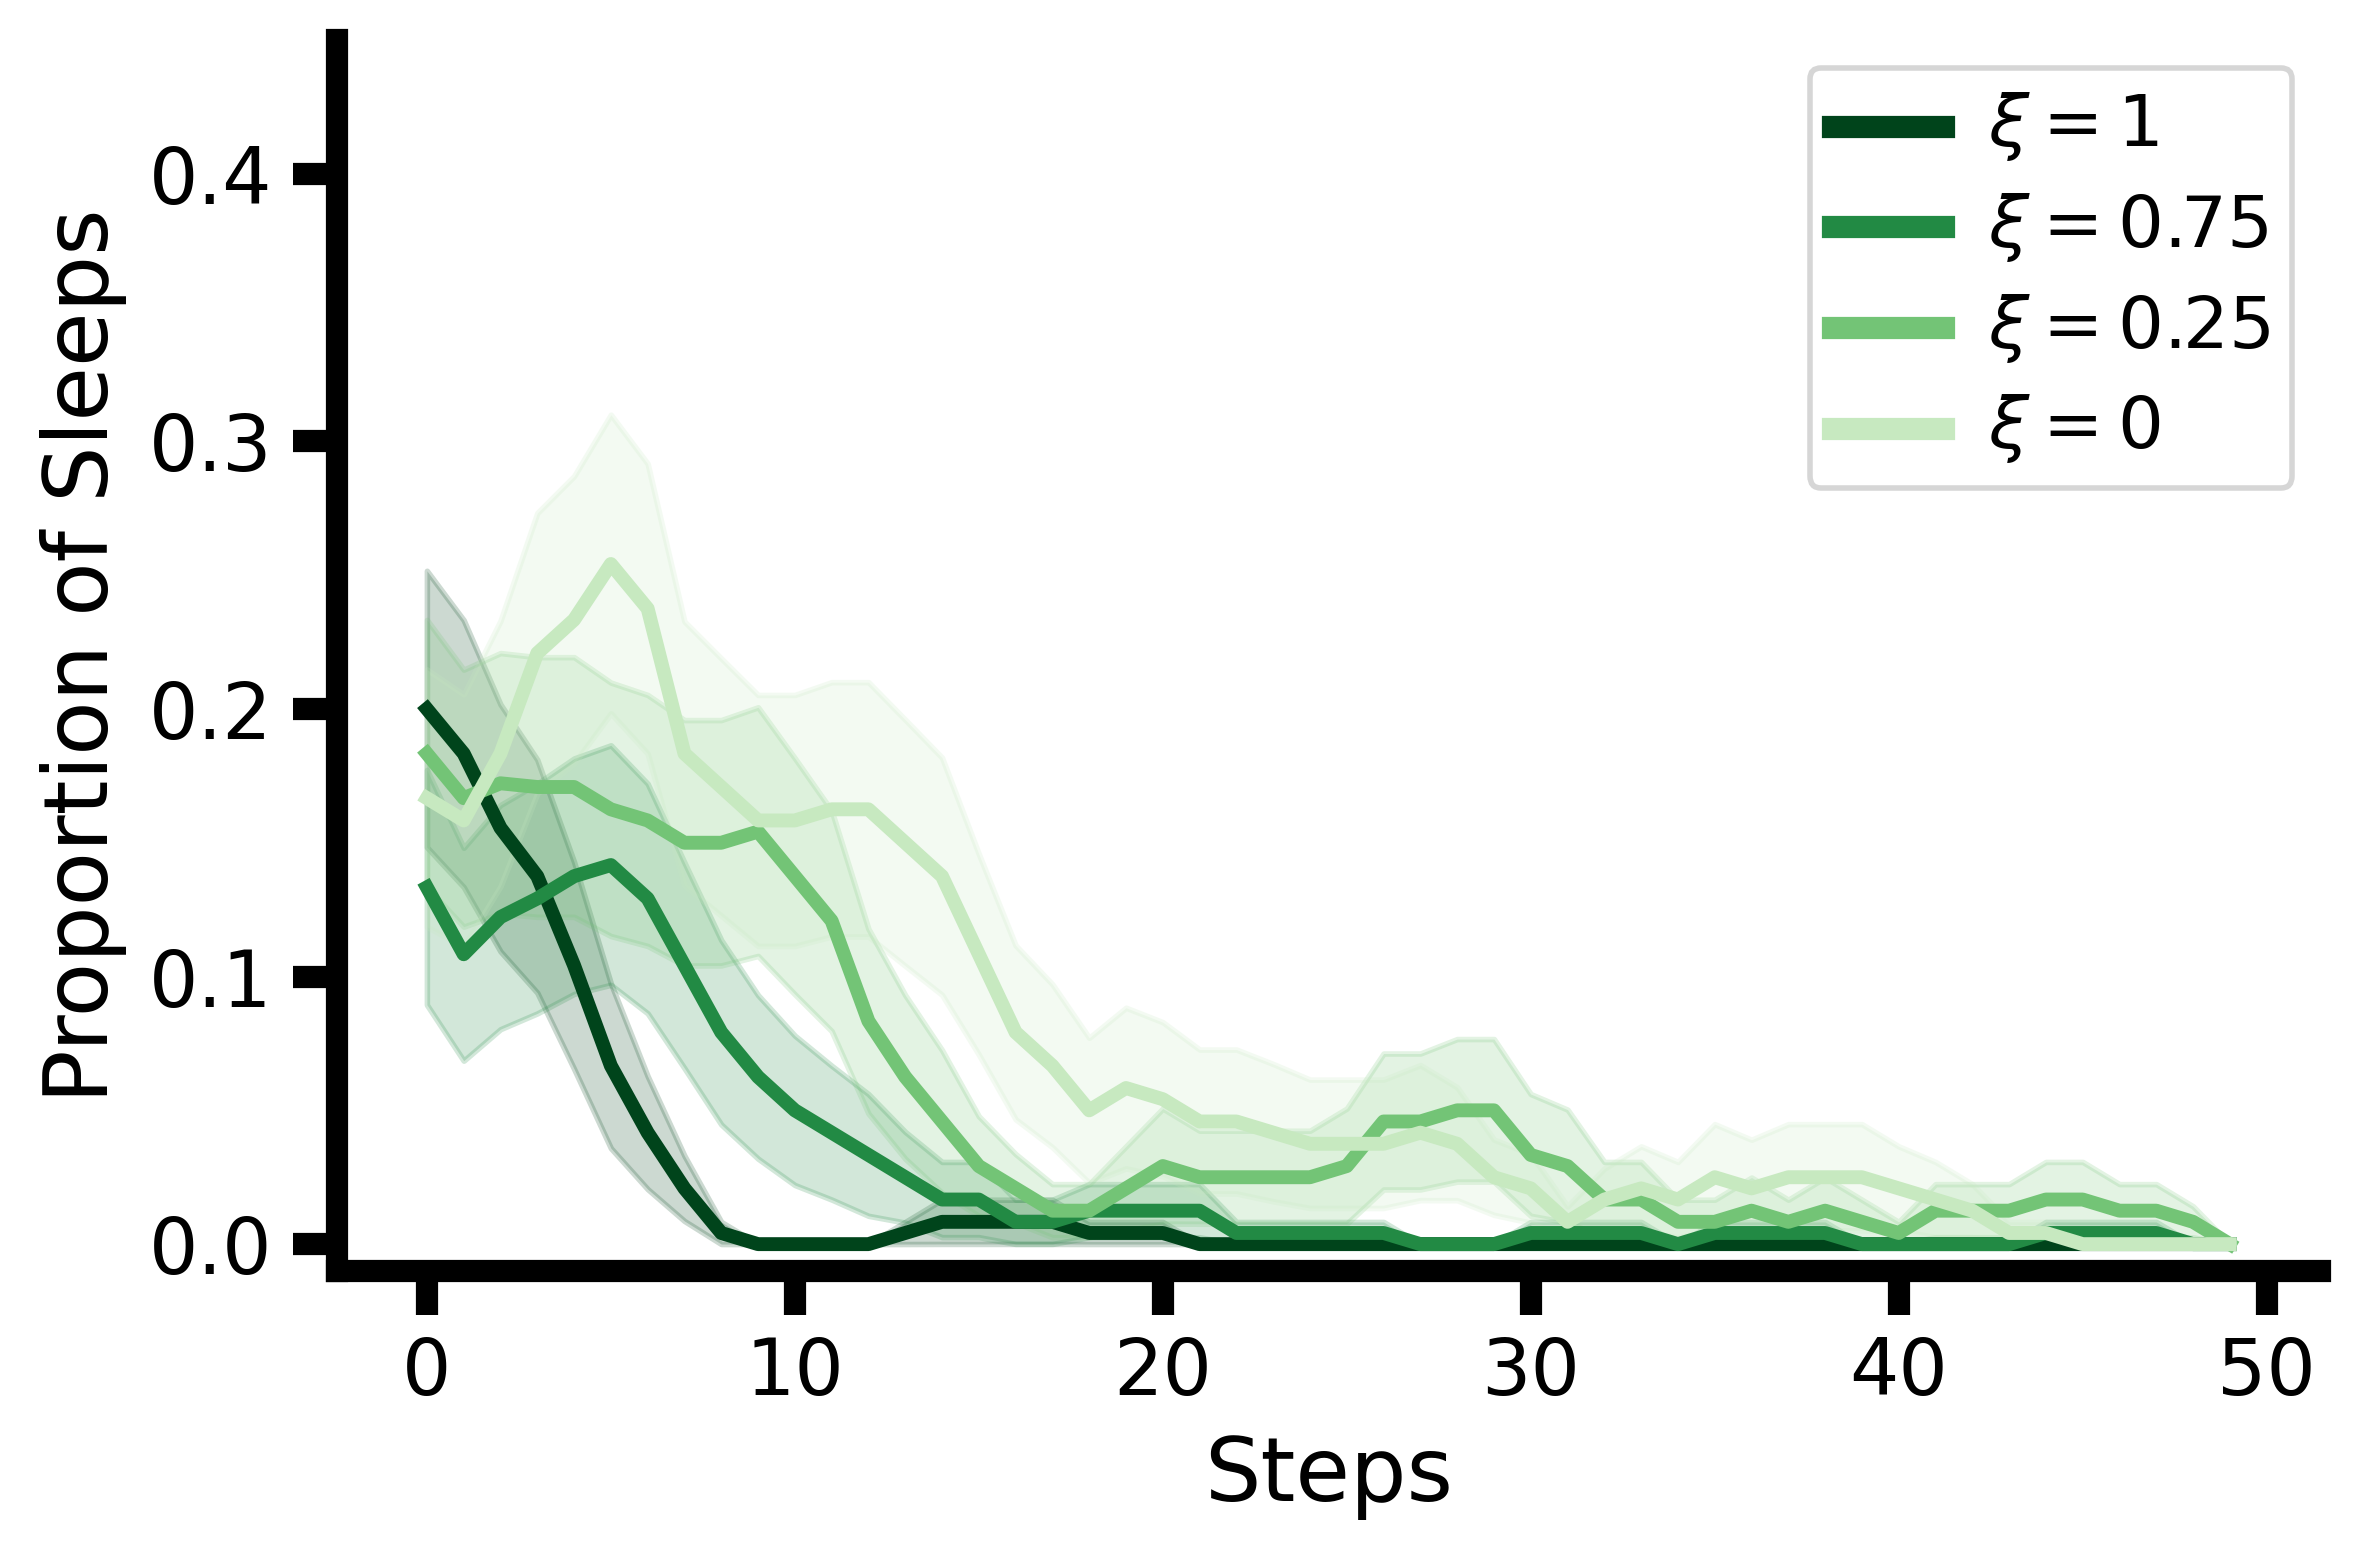

In [16]:
mean_probs = np.array([np.nanmean(sleep, axis=0) for sleep in sleeps])
stderr_probs = np.array([np.nanstd(sleep, axis=0)/np.sqrt(sleep.shape[0]) for sleep in sleeps])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = range(mean_probs.shape[1])

for i in range(len(mean_probs)):
    ax.plot(steps, mean_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

ax.legend()

ax.set_xlabel("Steps")
ax.set_ylabel("Proportion of Sleeps")

if ylim is not None:
    ax.set_ylim(ylim)

format_axis(ax)

plt.tight_layout()


In [17]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_humans.svg'))

#### Stats

In [18]:
cropped_sleeps = [np.nanmean(sleep[:,8:20], axis=1) for sleep in sleeps]
plotted_levels = effs_to_plot

In [19]:
## MEANS AND SEMS
for level, sleep in zip(plotted_levels, cropped_sleeps):
    print("Test Controllability ", level)
    print("Mean ", sleep.mean())
    print("StdErr ", sleep.std()/np.sqrt(sleep.shape[0]))
    print("N", sleep.shape[0])

Test Controllability  1
Mean  0.004166666666666667
StdErr  0.0023447143077964068
N 60
Test Controllability  0.75
Mean  0.023611111111111107
StdErr  0.007106896175619058
N 60
Test Controllability  0.25
Mean  0.05694444444444444
StdErr  0.011367131430344794
N 60
Test Controllability  0
Mean  0.10972222222222222
StdErr  0.015527214592582767
N 60


In [20]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_sleeps)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_sleeps), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.25  -0.0528 0.0023 -0.0909 -0.0147   True
   0.0   0.75  -0.0861    0.0 -0.1242  -0.048   True
   0.0    1.0  -0.1056    0.0 -0.1437 -0.0675   True
  0.25   0.75  -0.0333 0.1095 -0.0714  0.0048  False
  0.25    1.0  -0.0528 0.0023 -0.0909 -0.0147   True
  0.75    1.0  -0.0194 0.5507 -0.0575  0.0187  False
----------------------------------------------------


In [21]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_sleeps')
glm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    n_sleeps  
No. Observations:    540        Method:                REML      
No. Groups:          60         Scale:                 2.4121    
Min. group size:     9          Log-Likelihood:        -1067.6866
Max. group size:     9          Converged:             Yes       
Mean group size:     9.0                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.517    0.269 13.077 0.000  2.990  4.044
C(efficacy_C)[T.0.125]  0.733    0.284  2.586 0.010  0.178  1.289
C(efficacy_C)[T.0.25]  -0.983    0.284 -3.468 0.001 -1.539 -0.428
C(efficacy_C)[T.0.375] -0.733    0.284 -2.586 0.010 -1.289 -0.178
C(efficacy_C)[T.0.5]   -0.867    0.284 -3.056 0.002 -1.422 -0.311
C(efficacy_C)[T.0.625] -1.550    0.284 -5.466 0.000 -2.106 -0.994
C(efficacy_C)[T.0.75]  -2.233    0.284 -7.876 0.000 -2.789 -1.678
C(efficacy_C)[T.0.875] -2.450    0.284 -8.640 0.000 -3.006 -1.894
C(efficacy_C)[T.1.0]   -2.833    0.284 -9.992 0.000 -3.389 -2.278
Group Var               1.927    0.276                           
=================================================================

"""

### APE-trained Neural Networks

In [11]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

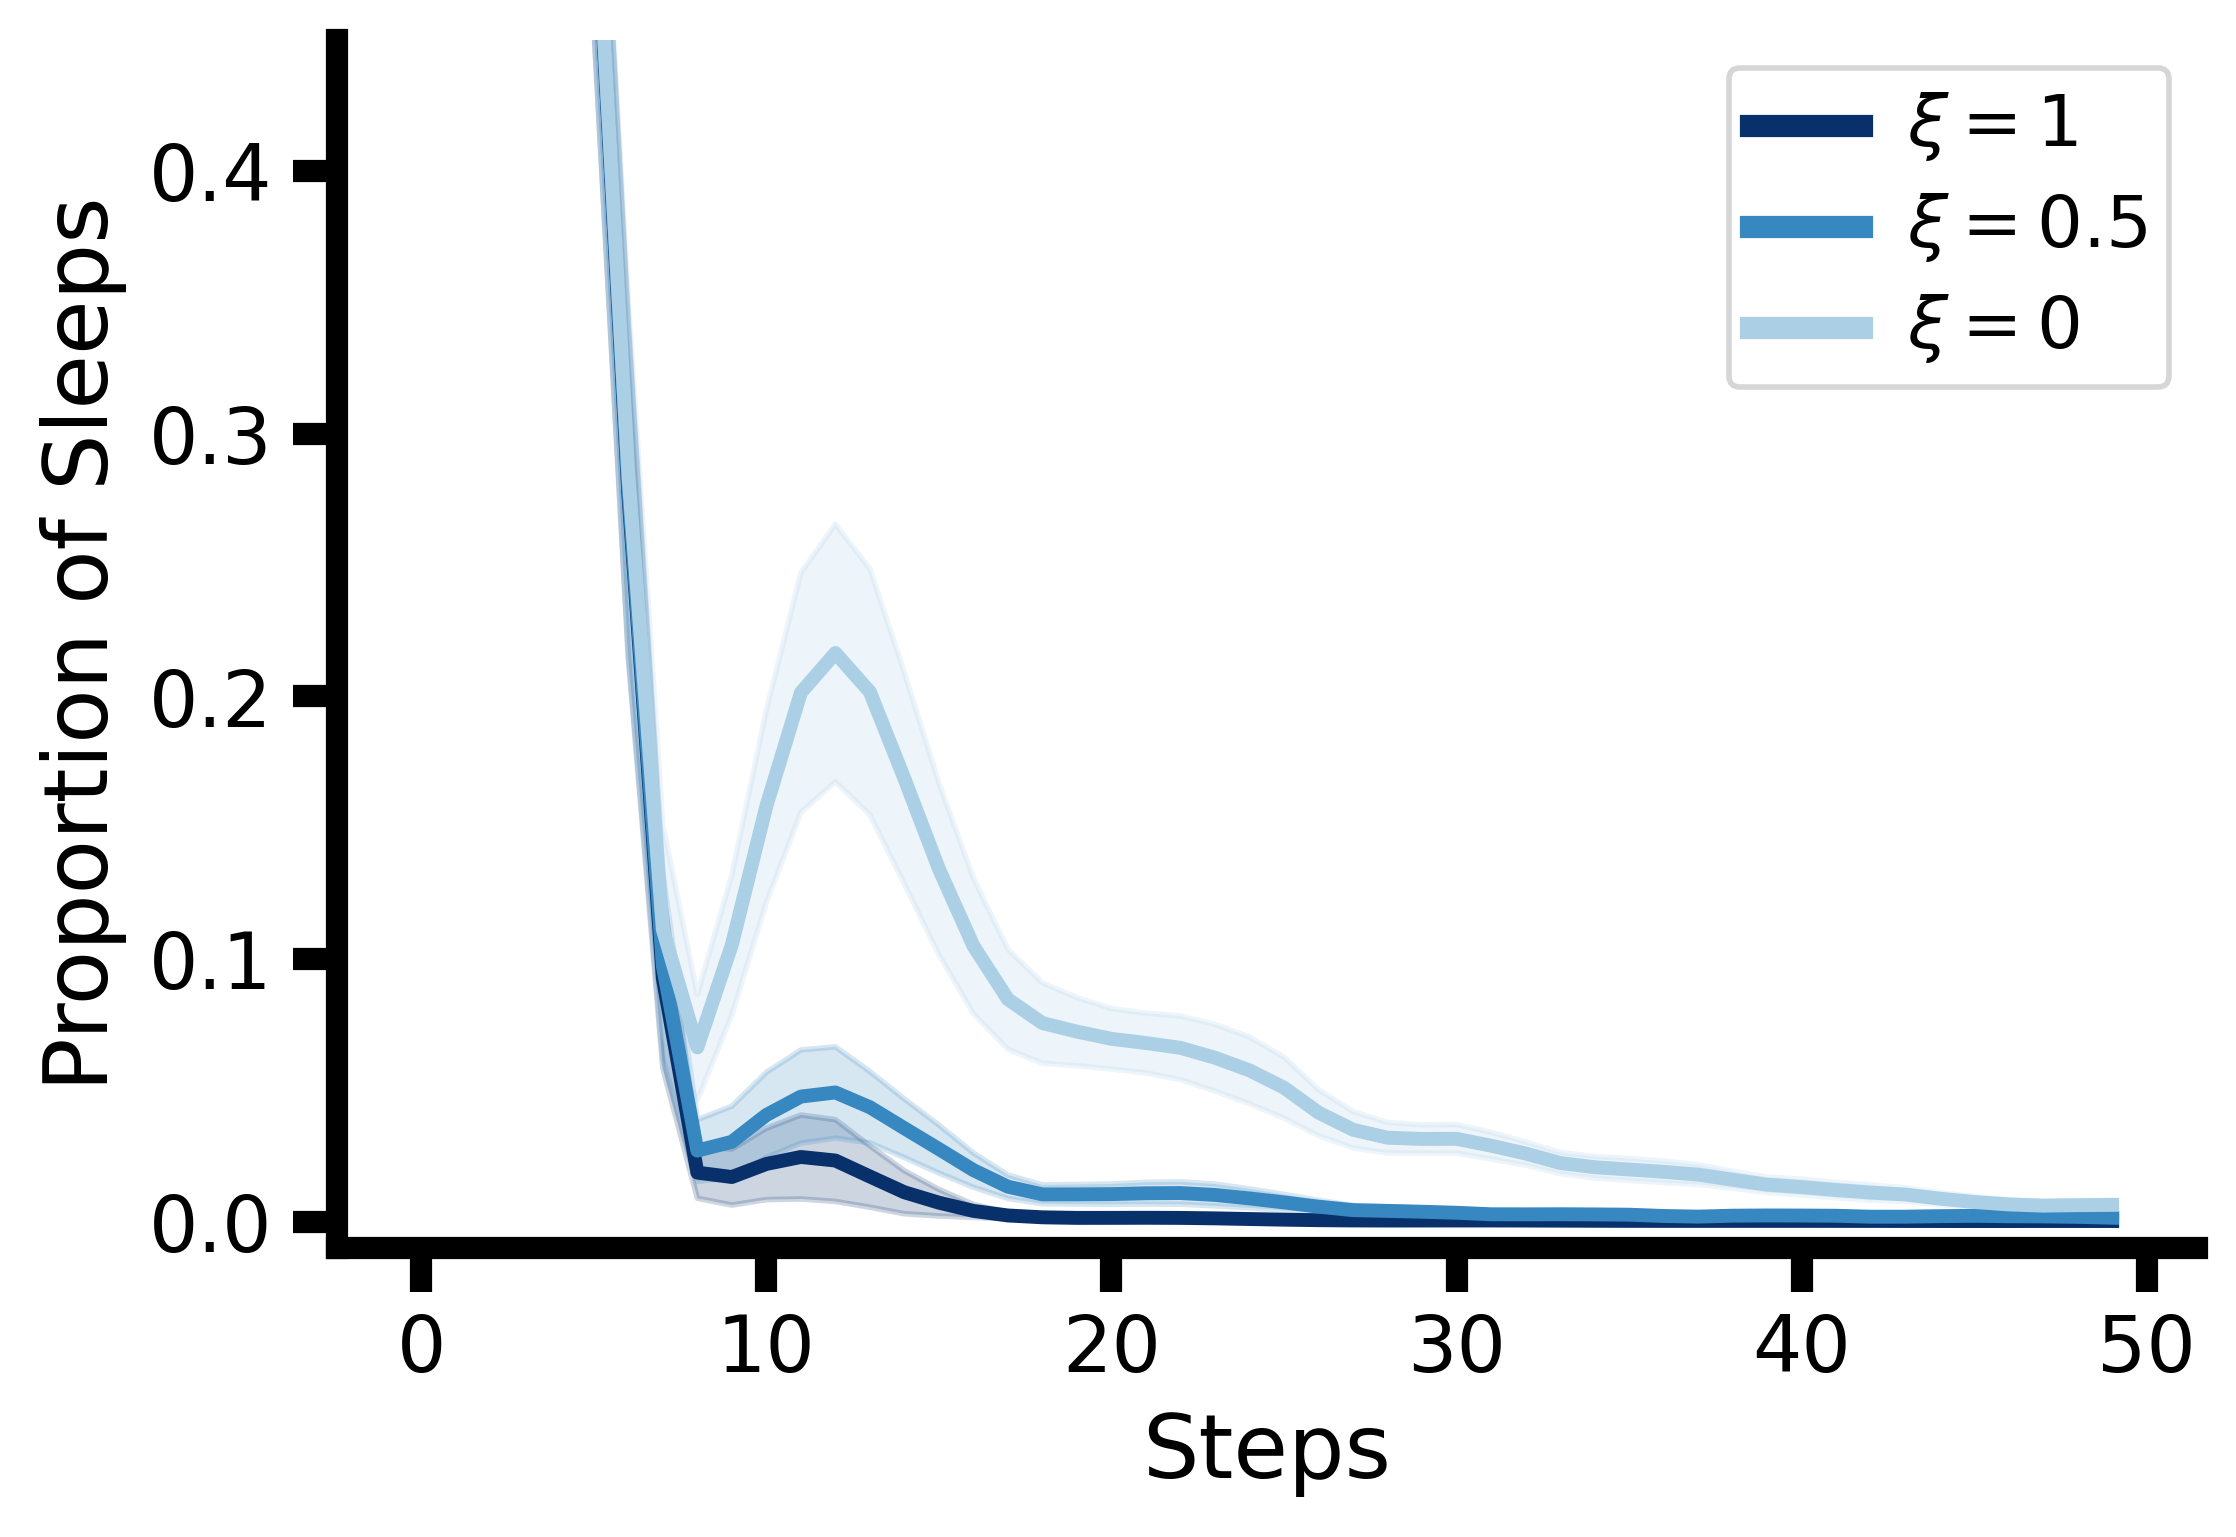

In [12]:
from test_analyses import frac_sleeps_lineplot

fig = frac_sleeps_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Sleeps")

In [13]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_apes.svg'))

### No APE Networks

In [14]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

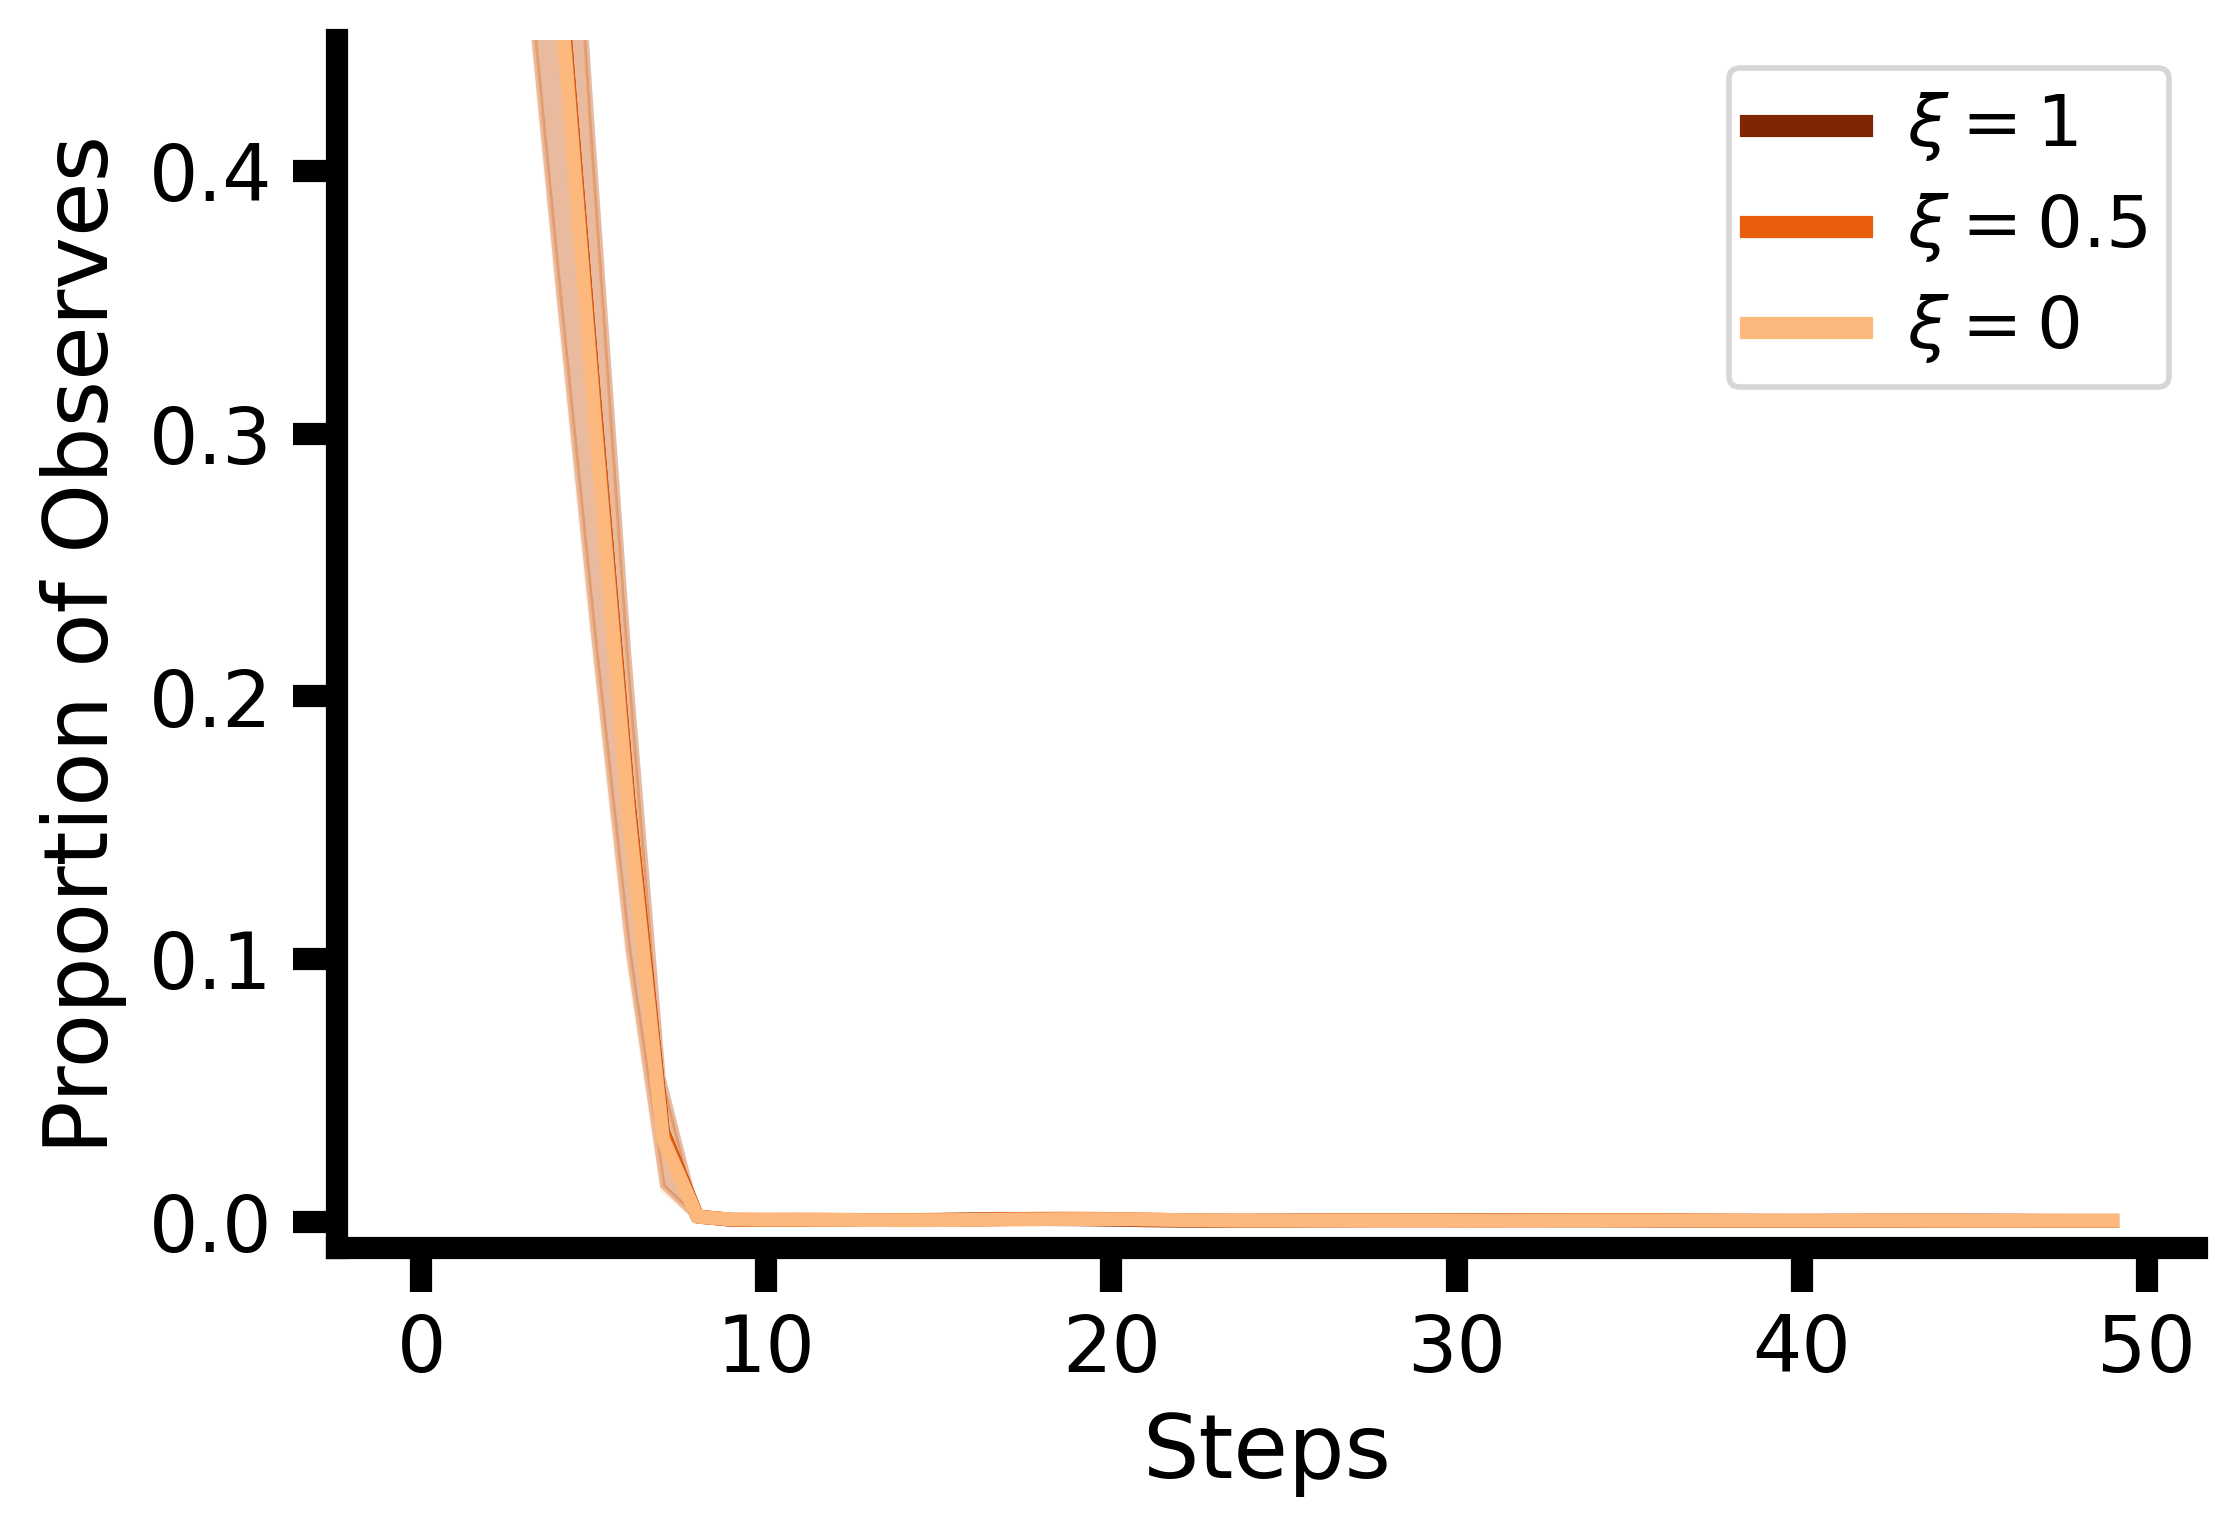

In [15]:
from test_analyses import frac_sleeps_lineplot

fig = frac_sleeps_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [16]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_noape.svg'))

## Panel B: Single-Episode Observations
### General Options

In [22]:
n_steps = 50
smoothing_window = 8
ylim = (-0.01, 0.3)

### Humans

In [23]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [26]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start)
observations = [transitions_test[:,3], transitions_test[:,2], transitions_test[:,1], transitions_test[:,0]] ## plotting highest efficacy first
observations = [observation == 0.5 for observation in observations]

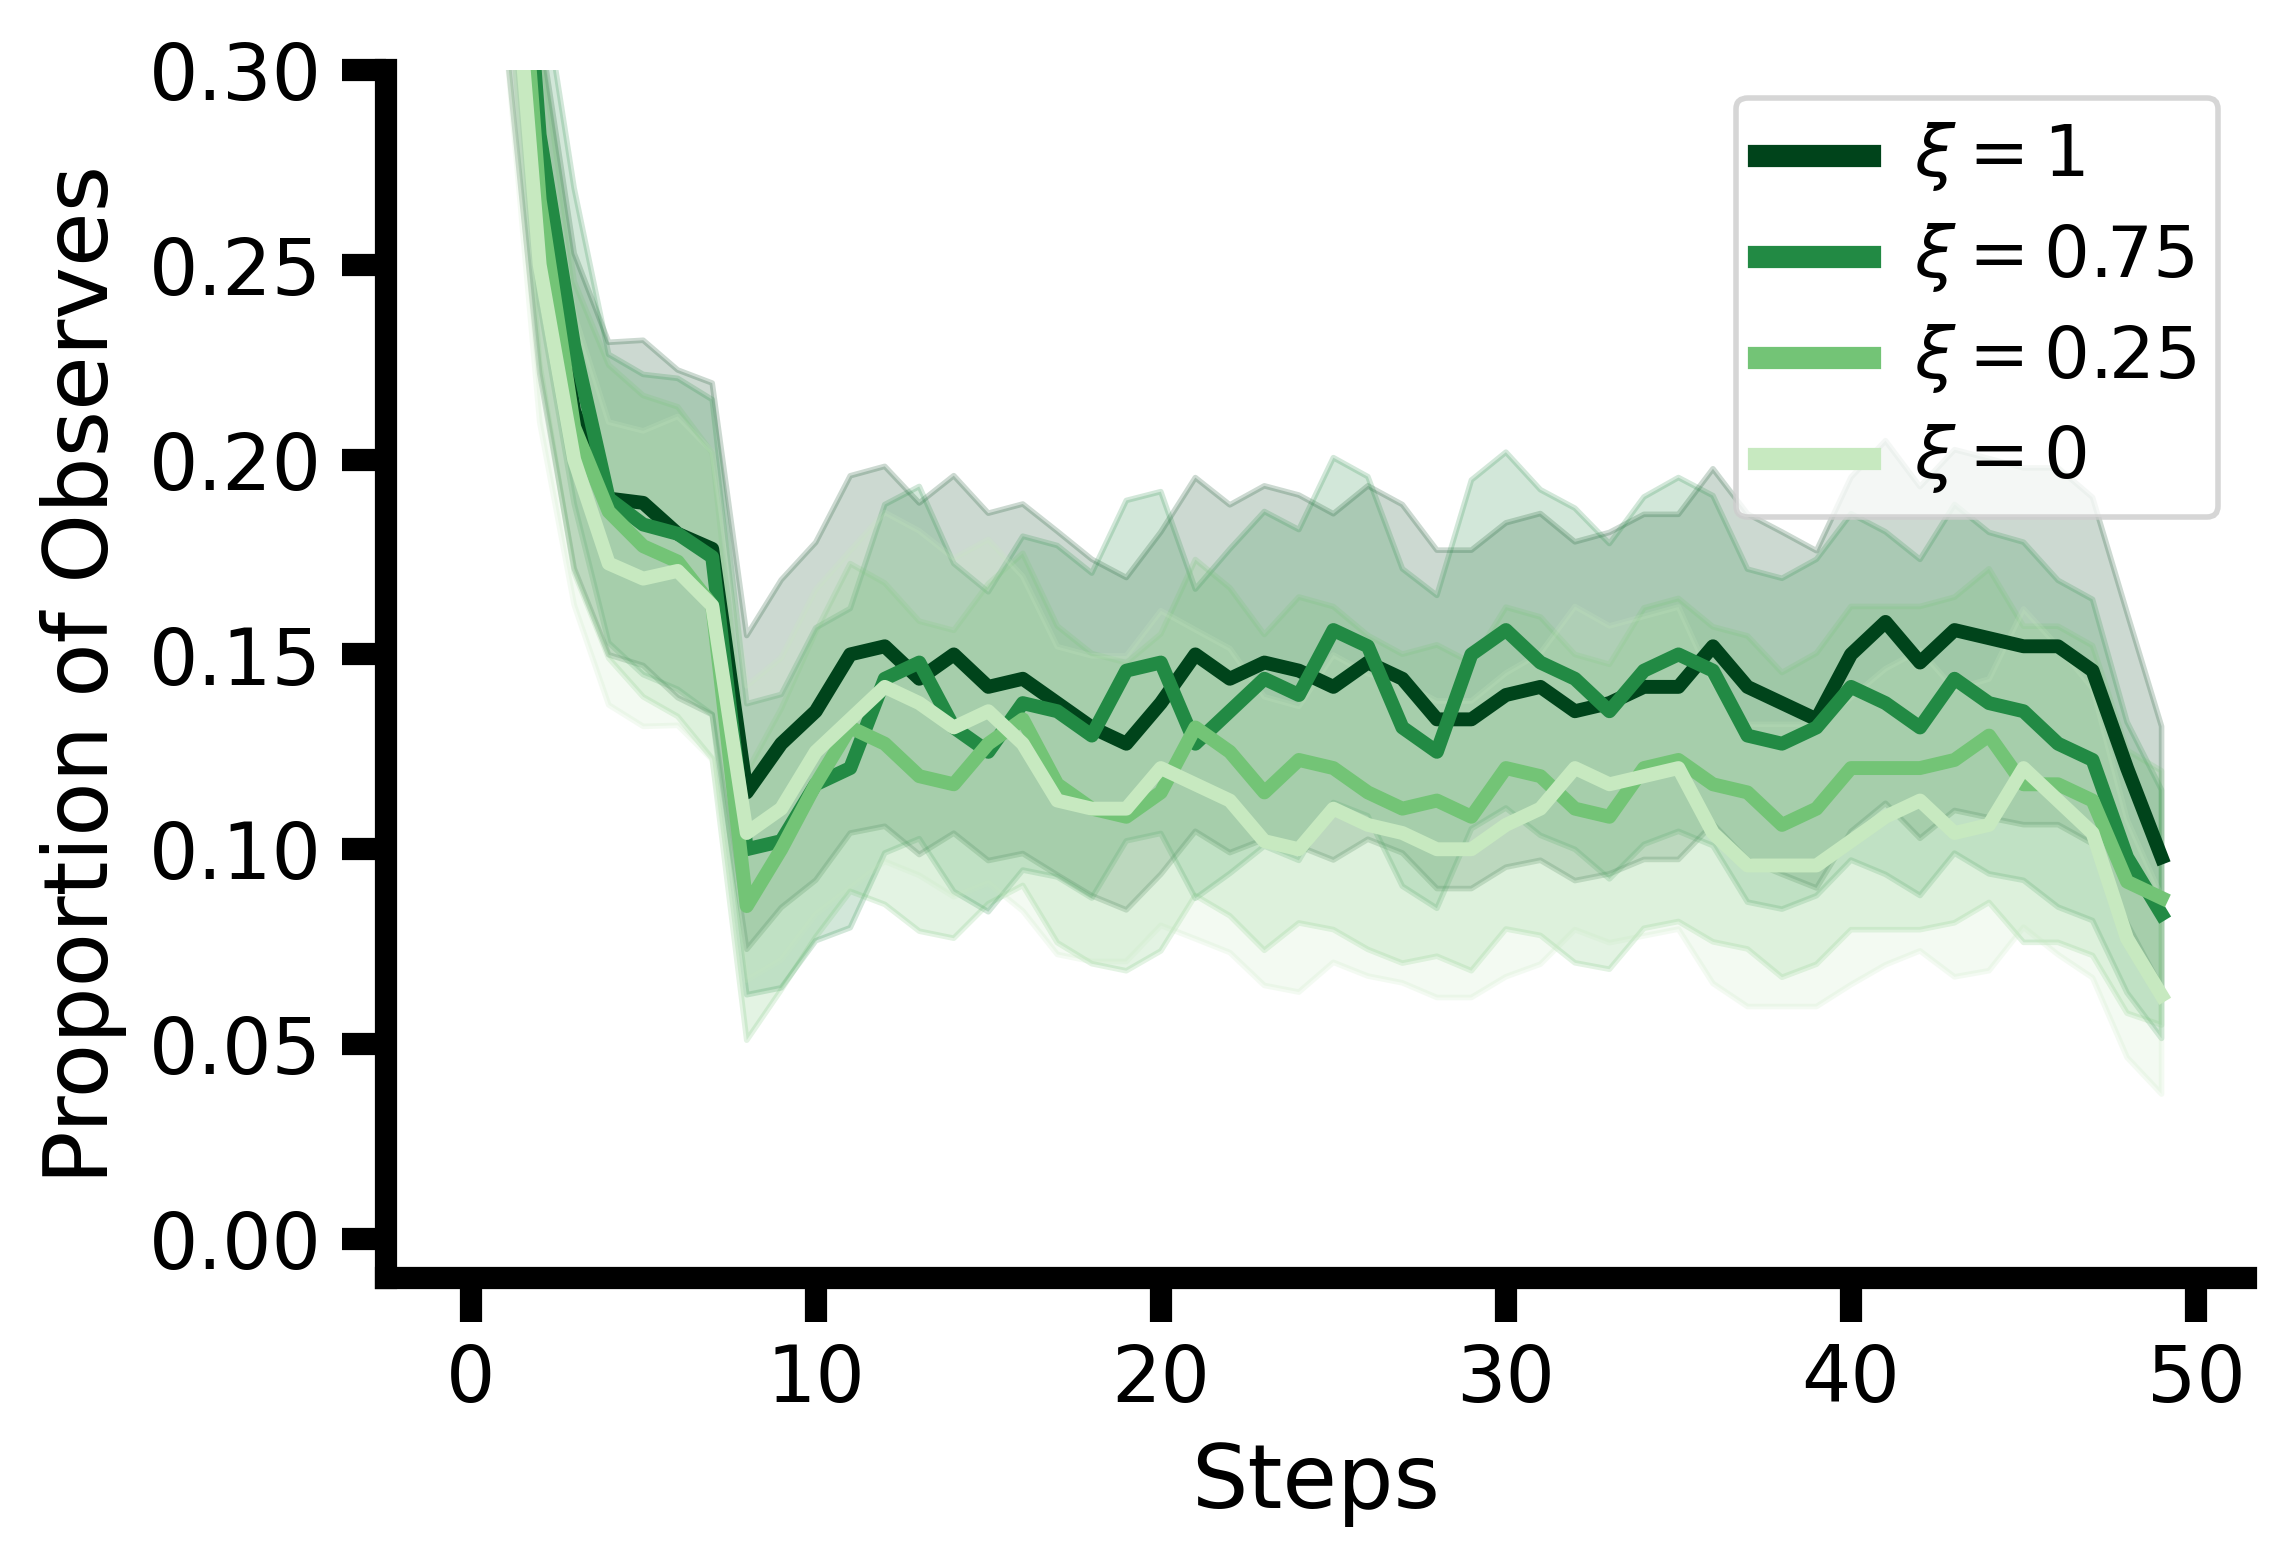

In [27]:
mean_peek_probs = np.array([observation.mean(axis=0) for observation in observations])
stderr_peek_probs = np.array([observation.std(axis=0)/np.sqrt(observation.shape[0]) for observation in observations])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_peek_probs = pd.DataFrame(mean_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_peek_probs = pd.DataFrame(stderr_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = range(mean_peek_probs.shape[1])

for i in range(len(mean_peek_probs)):
    ax.plot(steps, mean_peek_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.fill_between(steps, mean_peek_probs[i] - stderr_peek_probs[i], mean_peek_probs[i] + stderr_peek_probs[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)), alpha=0.2)

ax.legend()

ax.set_xlabel("Steps")
ax.set_ylabel("Proportion of Observes")

if ylim is not None:
    ax.set_ylim(ylim)

format_axis(ax)

In [28]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.svg'))

#### Stats

In [22]:
cropped_observations = [observation[:,15:].mean(axis=1) for observation in observations]
plotted_levels = [1, 0.5, 0]

In [23]:
## MEANS AND SEMS
for level, obs in zip(plotted_levels, cropped_observations):
    print("Test Controllability ", level)
    print("Mean ", obs.mean())
    print("StdErr ", obs.std()/np.sqrt(obs.shape[0]))
    print("N", obs.shape[0])

Test Controllability  1
Mean  0.11801242236024848
StdErr  0.009606617498700929
N 46
Test Controllability  0.5
Mean  0.10725274725274725
StdErr  0.009966120979990702
N 65
Test Controllability  0
Mean  0.11490683229813664
StdErr  0.011093144416339643
N 46


In [24]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_observations)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_observations), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    0.5  -0.0077 0.8583  -0.042 0.0267  False
   0.0    1.0   0.0031 0.9787 -0.0341 0.0403  False
   0.5    1.0   0.0108 0.7397 -0.0236 0.0451  False
---------------------------------------------------


In [25]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    n_observes
No. Observations:    999        Method:                REML      
No. Groups:          111        Scale:                 2.5645    
Min. group size:     9          Log-Likelihood:        -2082.7629
Max. group size:     9          Converged:             Yes       
Mean group size:     9.0                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.068    0.471 12.876 0.000  5.145  6.992
C(efficacy_C)[T.0.125] -0.027    0.215 -0.126 0.900 -0.448  0.394
C(efficacy_C)[T.0.25]  -0.072    0.215 -0.335 0.737 -0.493  0.349
C(efficacy_C)[T.0.375]  0.541    0.215  2.515 0.012  0.119  0.962
C(efficacy_C)[T.0.5]    0.324    0.215  1.509 0.131 -0.097  0.746
C(efficacy_C)[T.0.625]  0.189    0.215  0.880 0.379 -0.232  0.610
C(efficacy_C)[T.0.75]   0.252    0.215  1.173 0.241 -0.169  0.674
C(efficacy_C)[T.0.875]  0.423    0.215  1.970 0.049  0.002  0.845
C(efficacy_C)[T.1.0]    0.189    0.215  0.880 0.379 -0.232  0.610
C(group_C)[T.True]     -0.824    0.587 -1.405 0.160 -1.974  0.326
Group Var               8.987    0.831                           
=================================================================

"""

### APE-trained Neural Networks

In [26]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

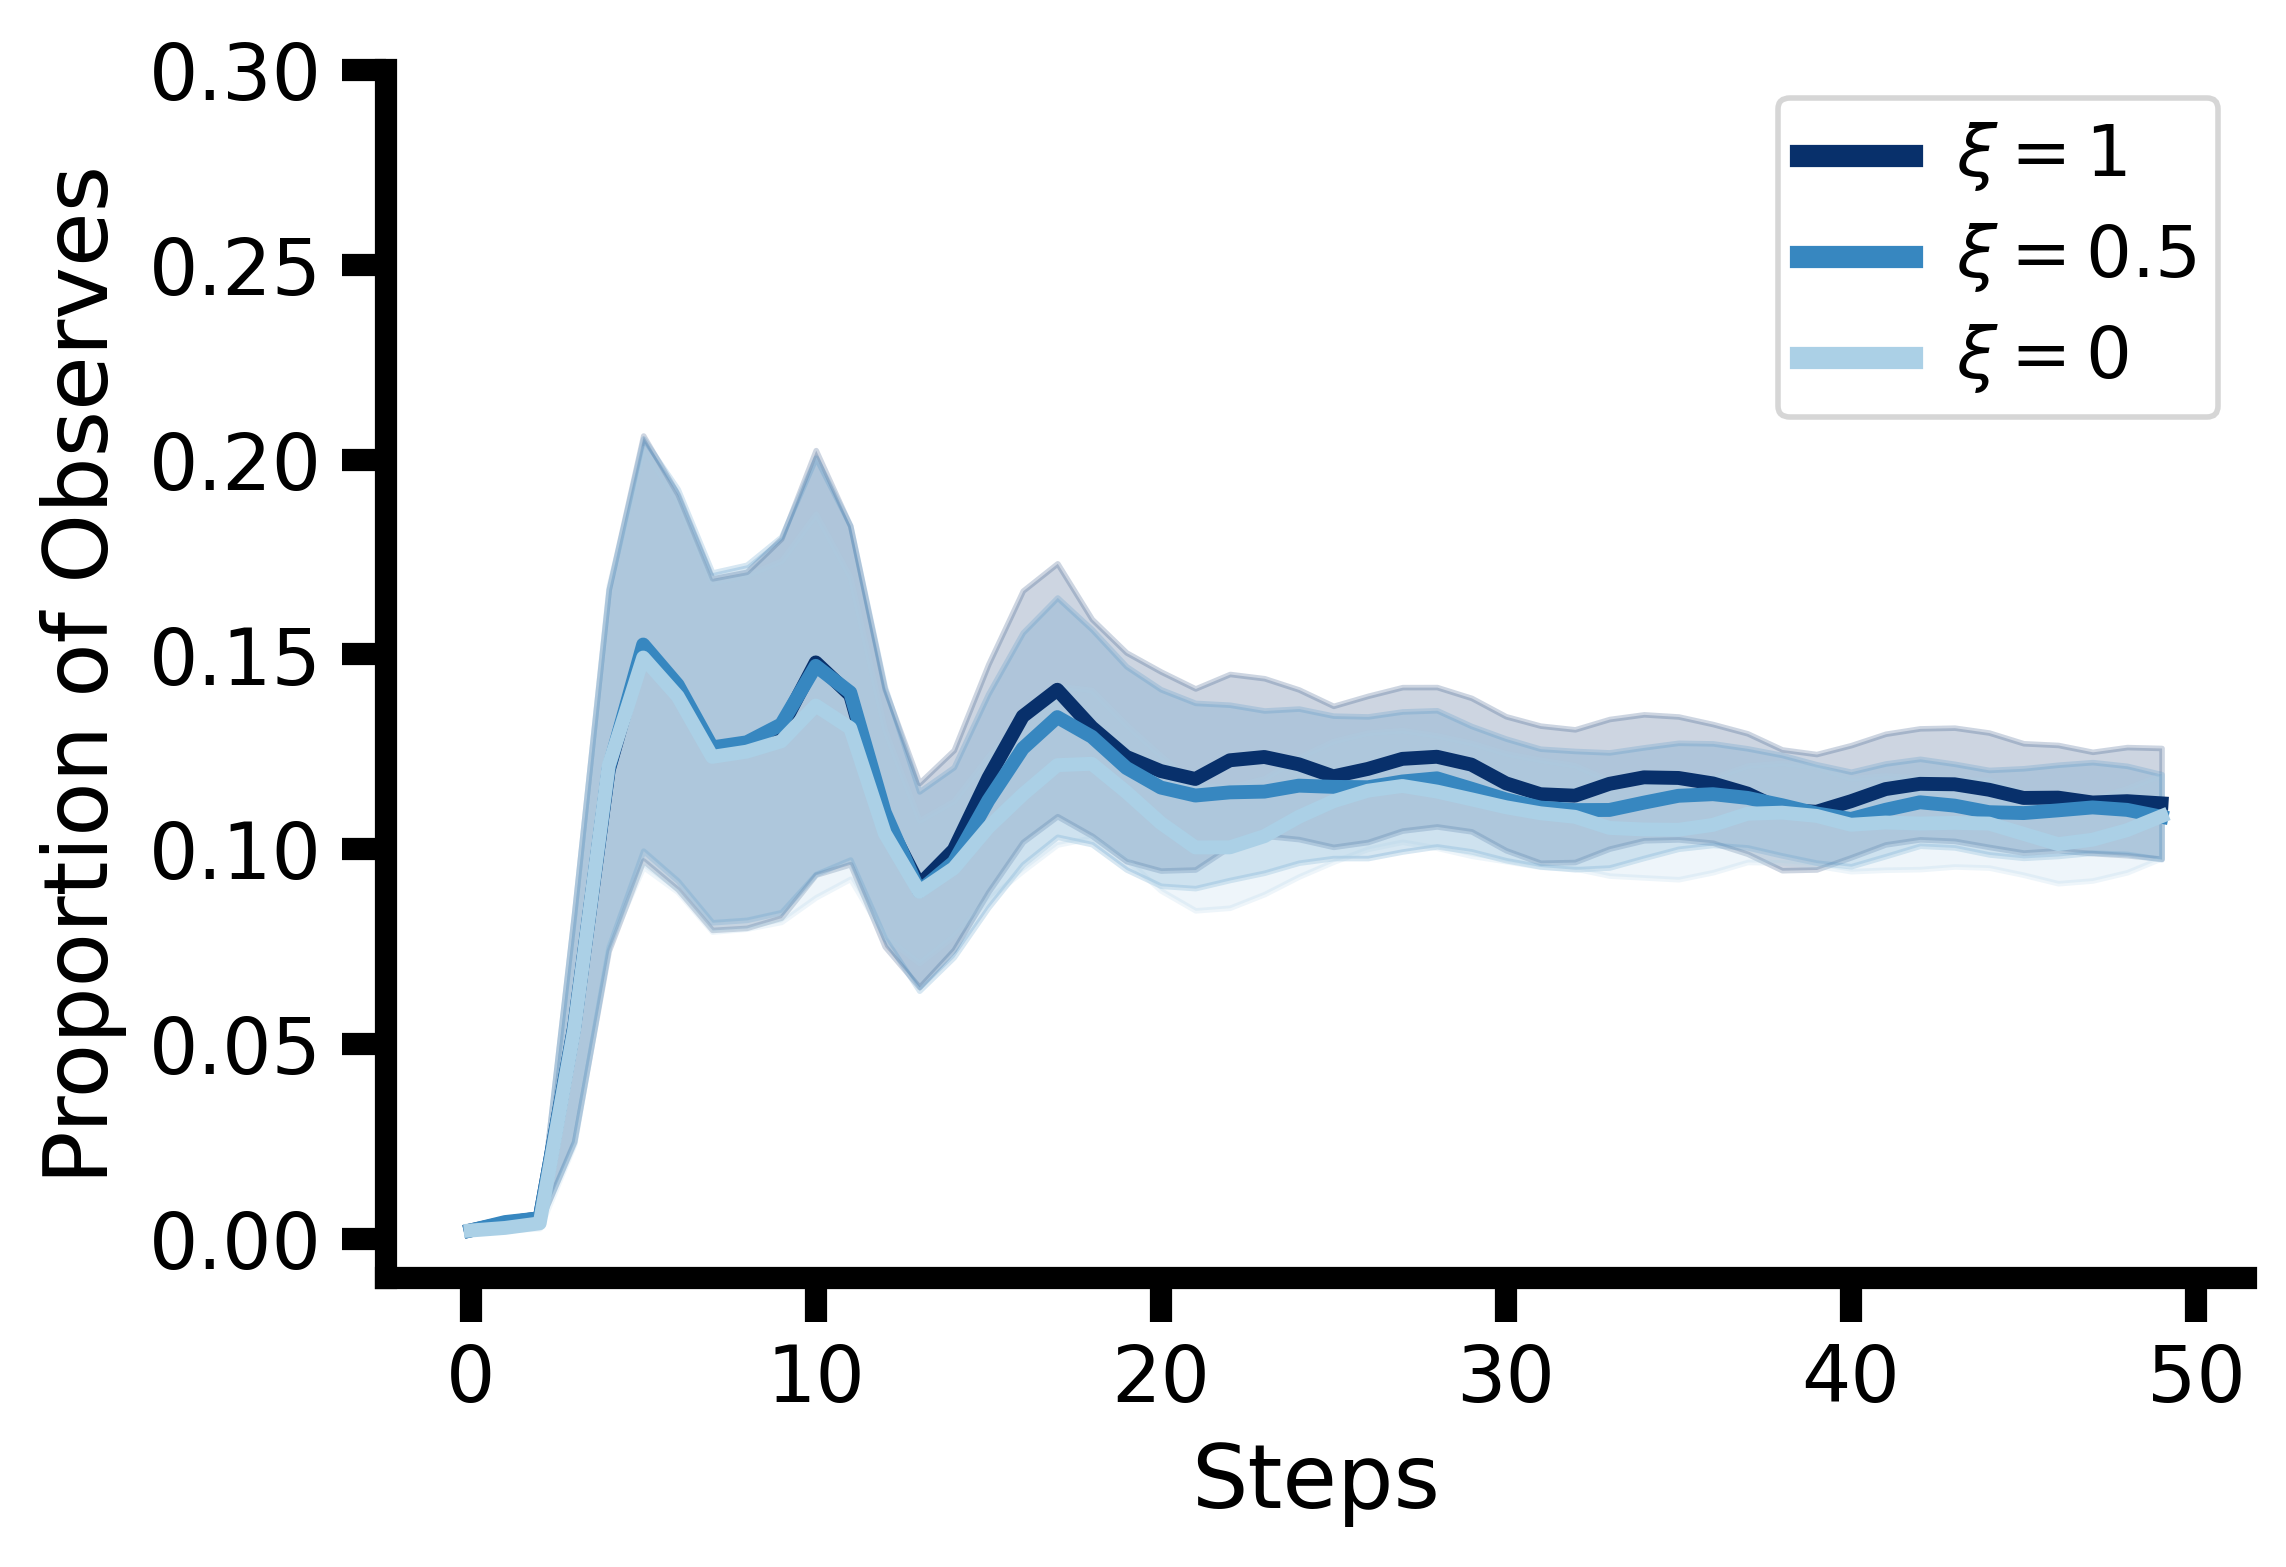

In [27]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Observes")

In [28]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_ape.svg'))

### No-APE Neural Networks

In [29]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

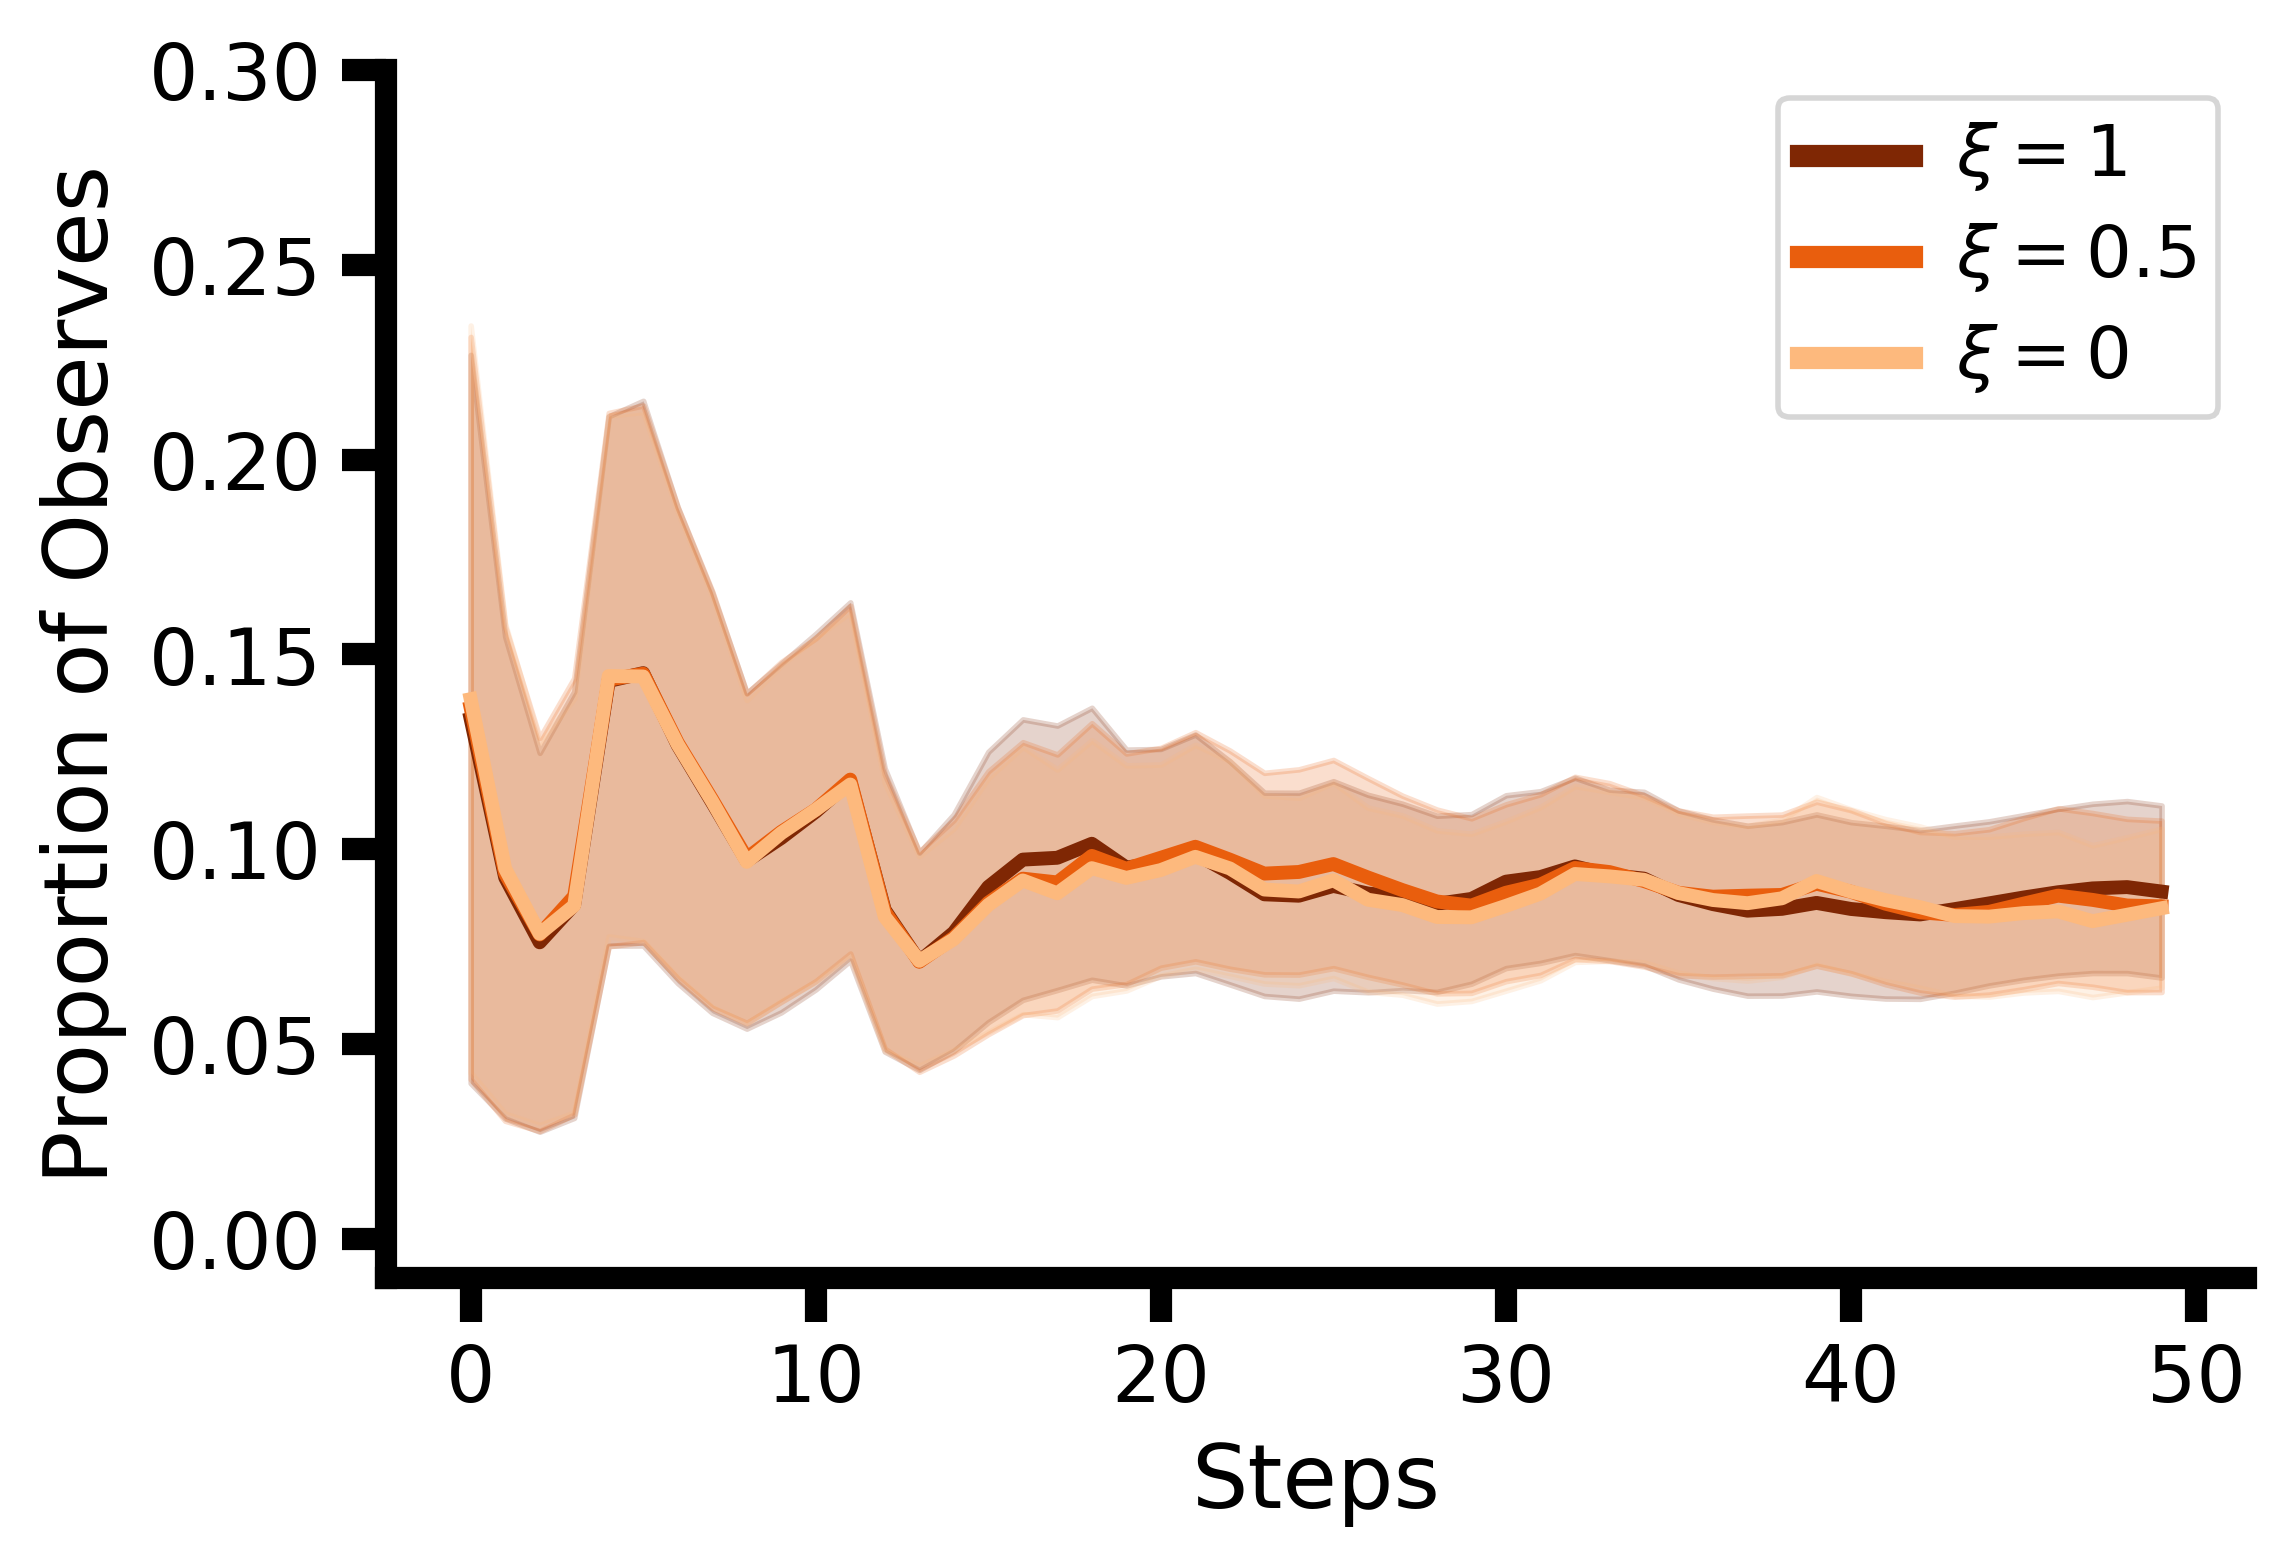

In [30]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [31]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.svg'))

## Panel C: Proportion Correct Bets
### General Options

In [29]:
ylim = (0, 1.0)
smoothing_window = 8

### Humans

In [30]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [38]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start)
correct_takes = transitions_test
correct_takes = [correct_takes[:,3], correct_takes[:,2], correct_takes[:,1], correct_takes[:,0]] ## plotting highest efficacy first

## convert observations to np.nans
for correct_take in correct_takes:
    correct_take[correct_take == 0.5] = np.nan
    correct_take[correct_take == -1] = np.nan

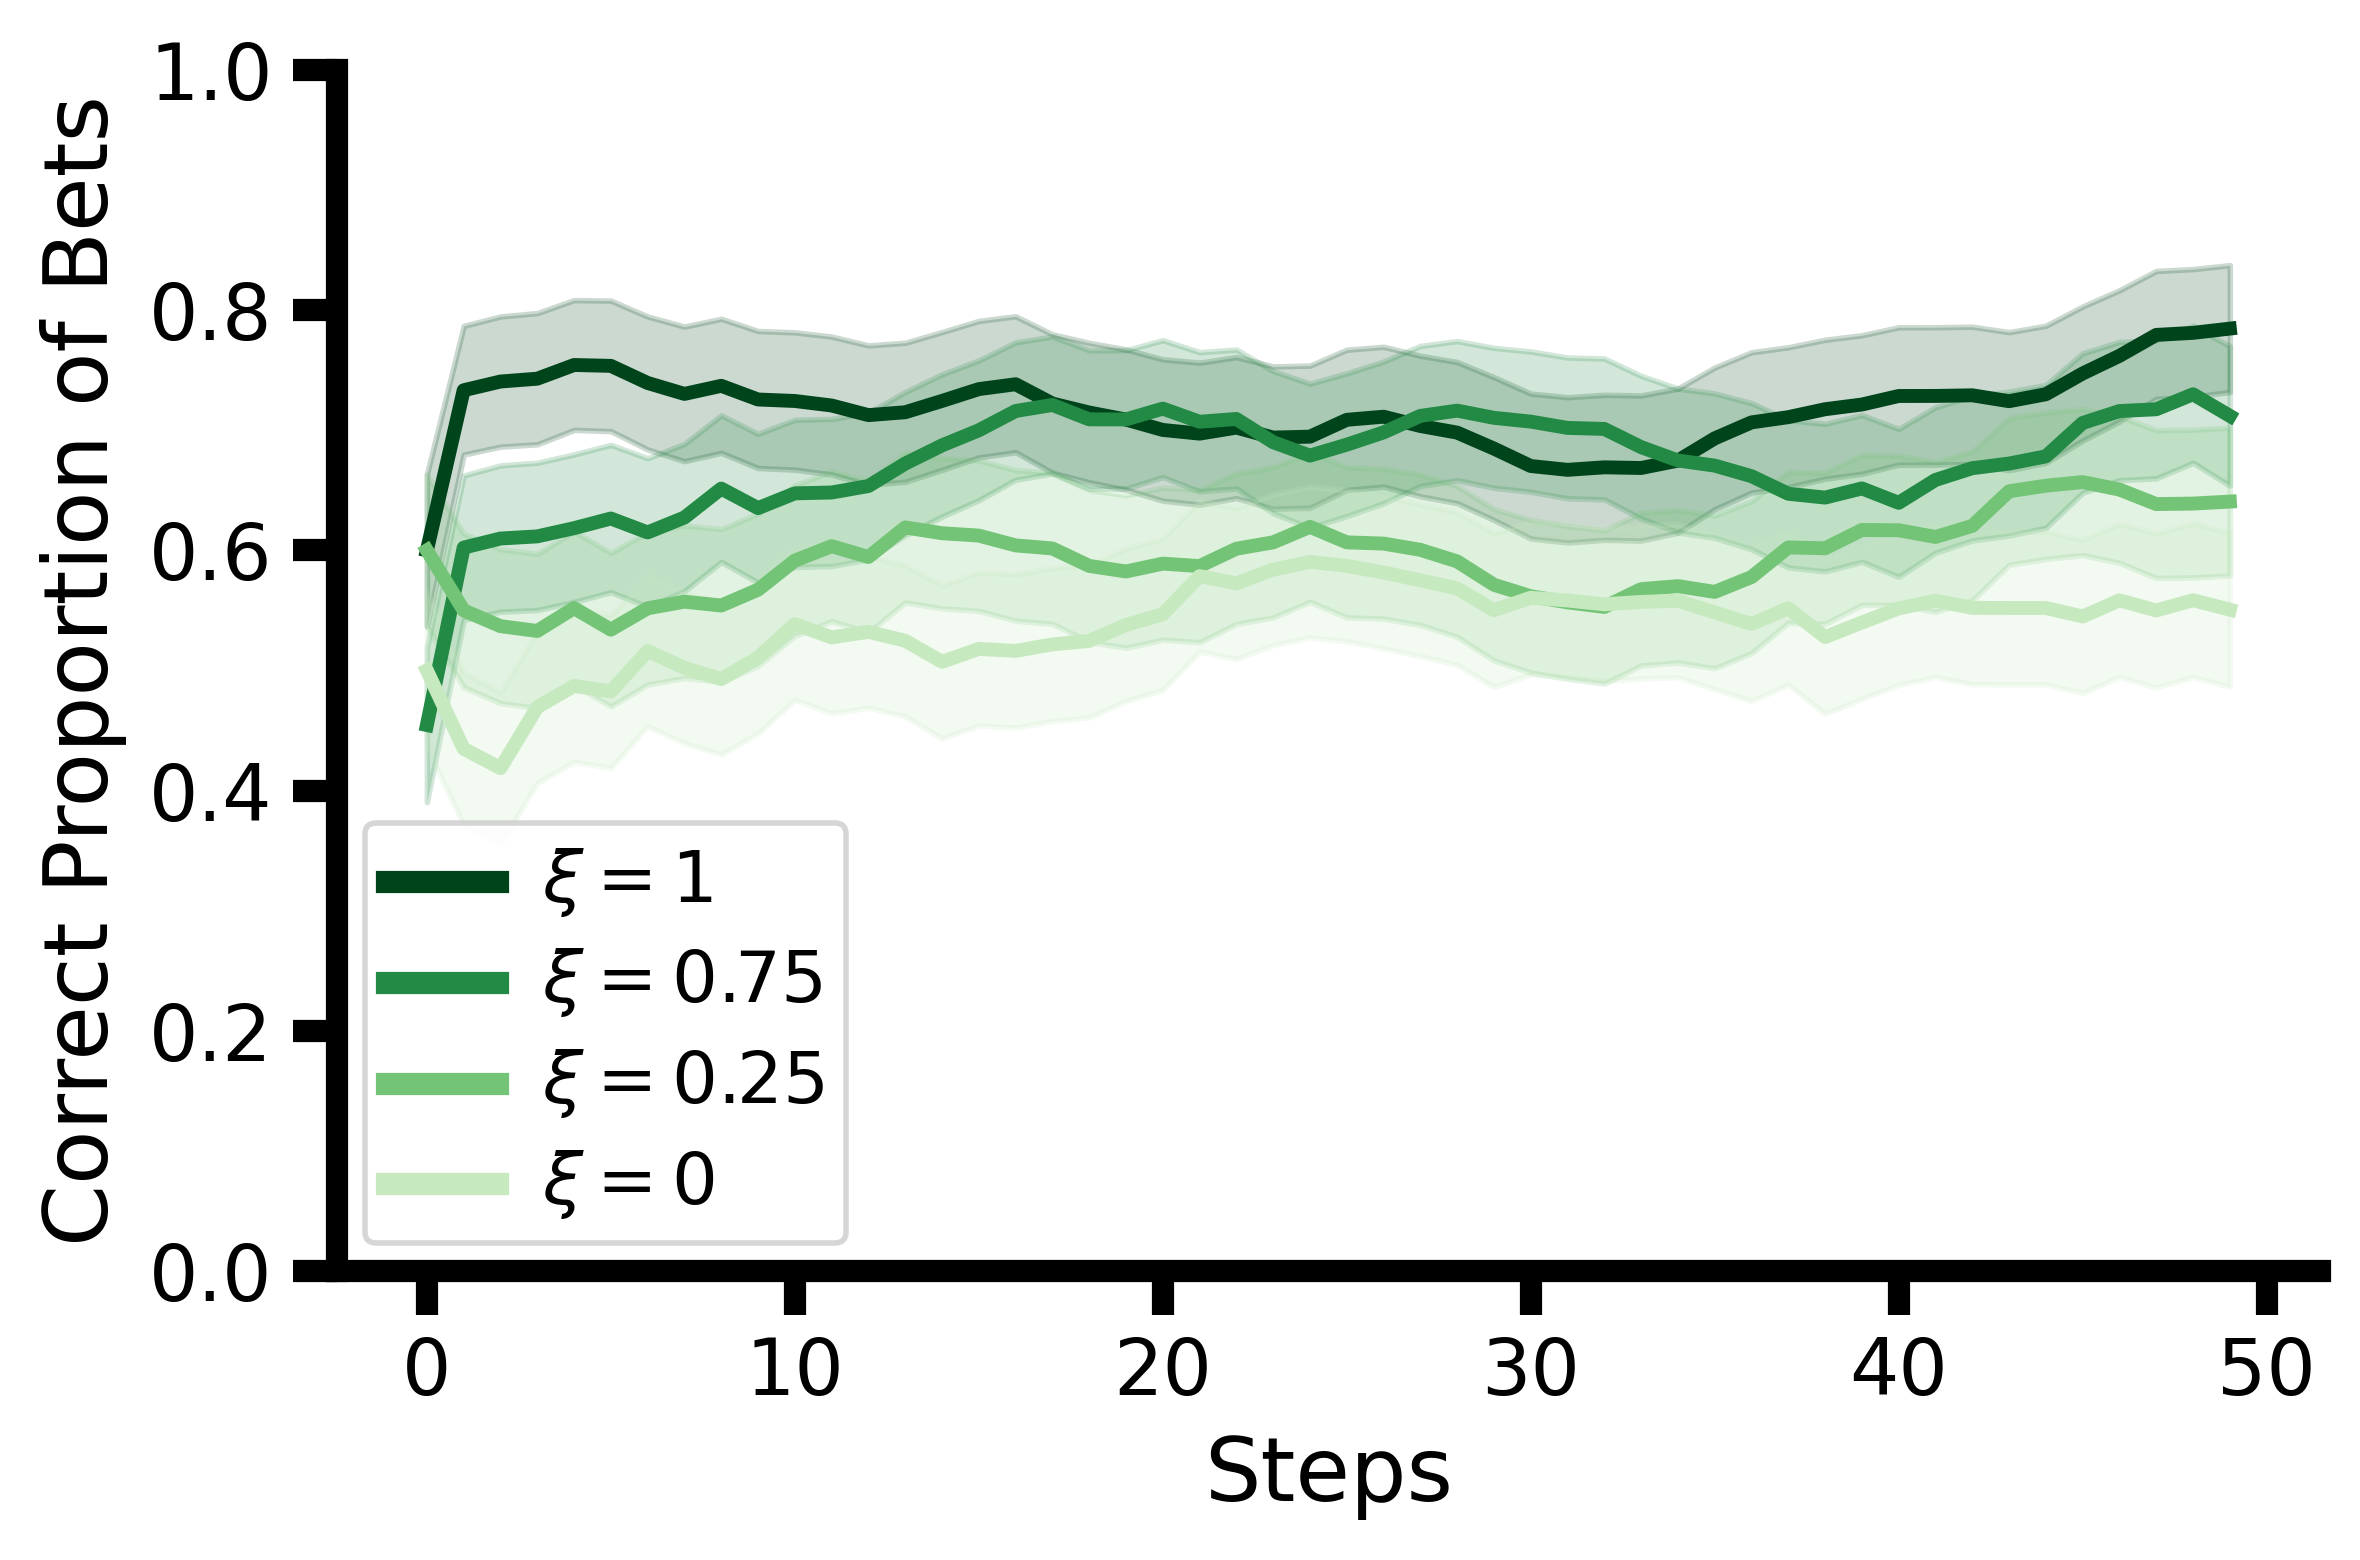

In [39]:
mean_probs = np.array([np.nanmean(correct_take, axis=0) for correct_take in correct_takes])
stderr_probs = np.array([np.nanstd(correct_take, axis=0)/np.sqrt(correct_take.shape[0]) for correct_take in correct_takes])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = range(mean_probs.shape[1])

for i in range(len(mean_probs)):
    ax.plot(steps, mean_probs[i], label=r"$\xi=$"+ str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

ax.legend()

ax.set_xlabel("Steps")
ax.set_ylabel("Correct Proportion of Bets")

if ylim is not None:
    ax.set_ylim(ylim)

format_axis(ax)

plt.tight_layout()


In [40]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.svg'))

### APE-trained Neural Network

In [37]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files

traj_base = os.path.join('data', 'eval', 'levc', )
traj_timestamp = '20240311133201'

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

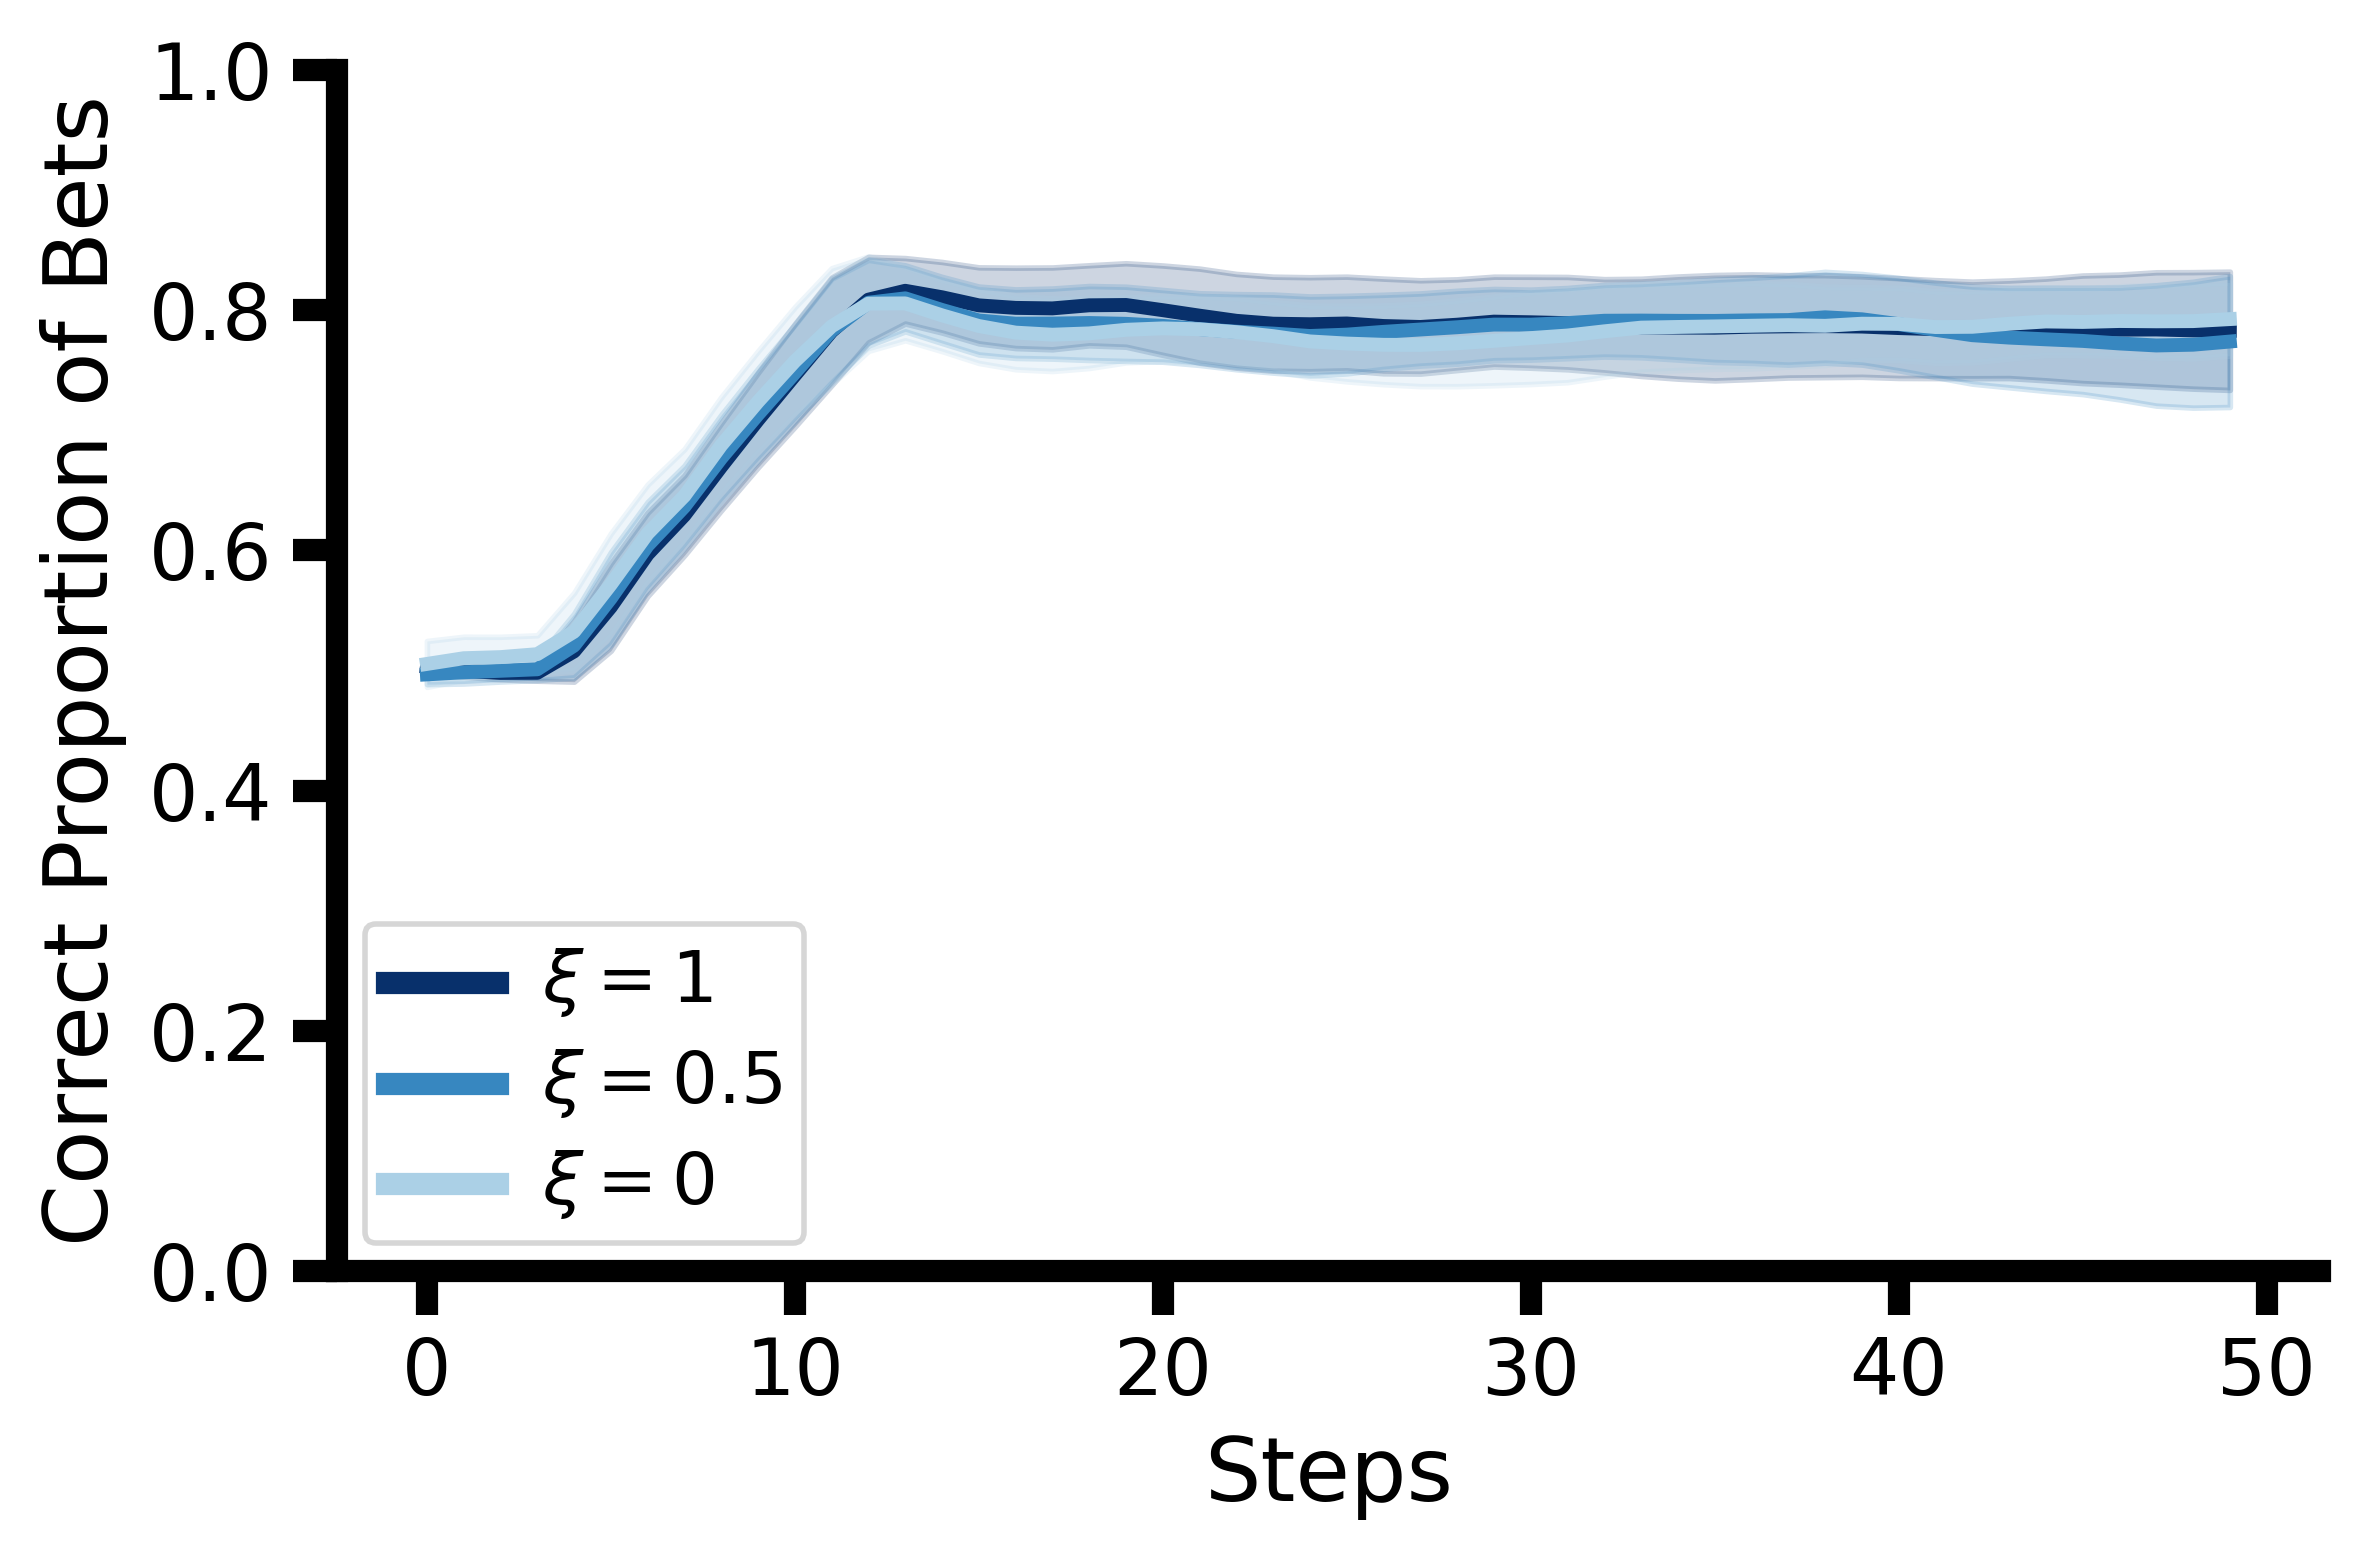

In [38]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, trajss_ps_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Correct Proportion of Bets", includes_sleep=True)

In [39]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.svg'))

### No APE Neural Network

In [40]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

trajss_ps_taus_control = np.array(trajss_ps_taus_control)
trajss_ps_taus_control = trajss_ps_taus_control[:, ::4]

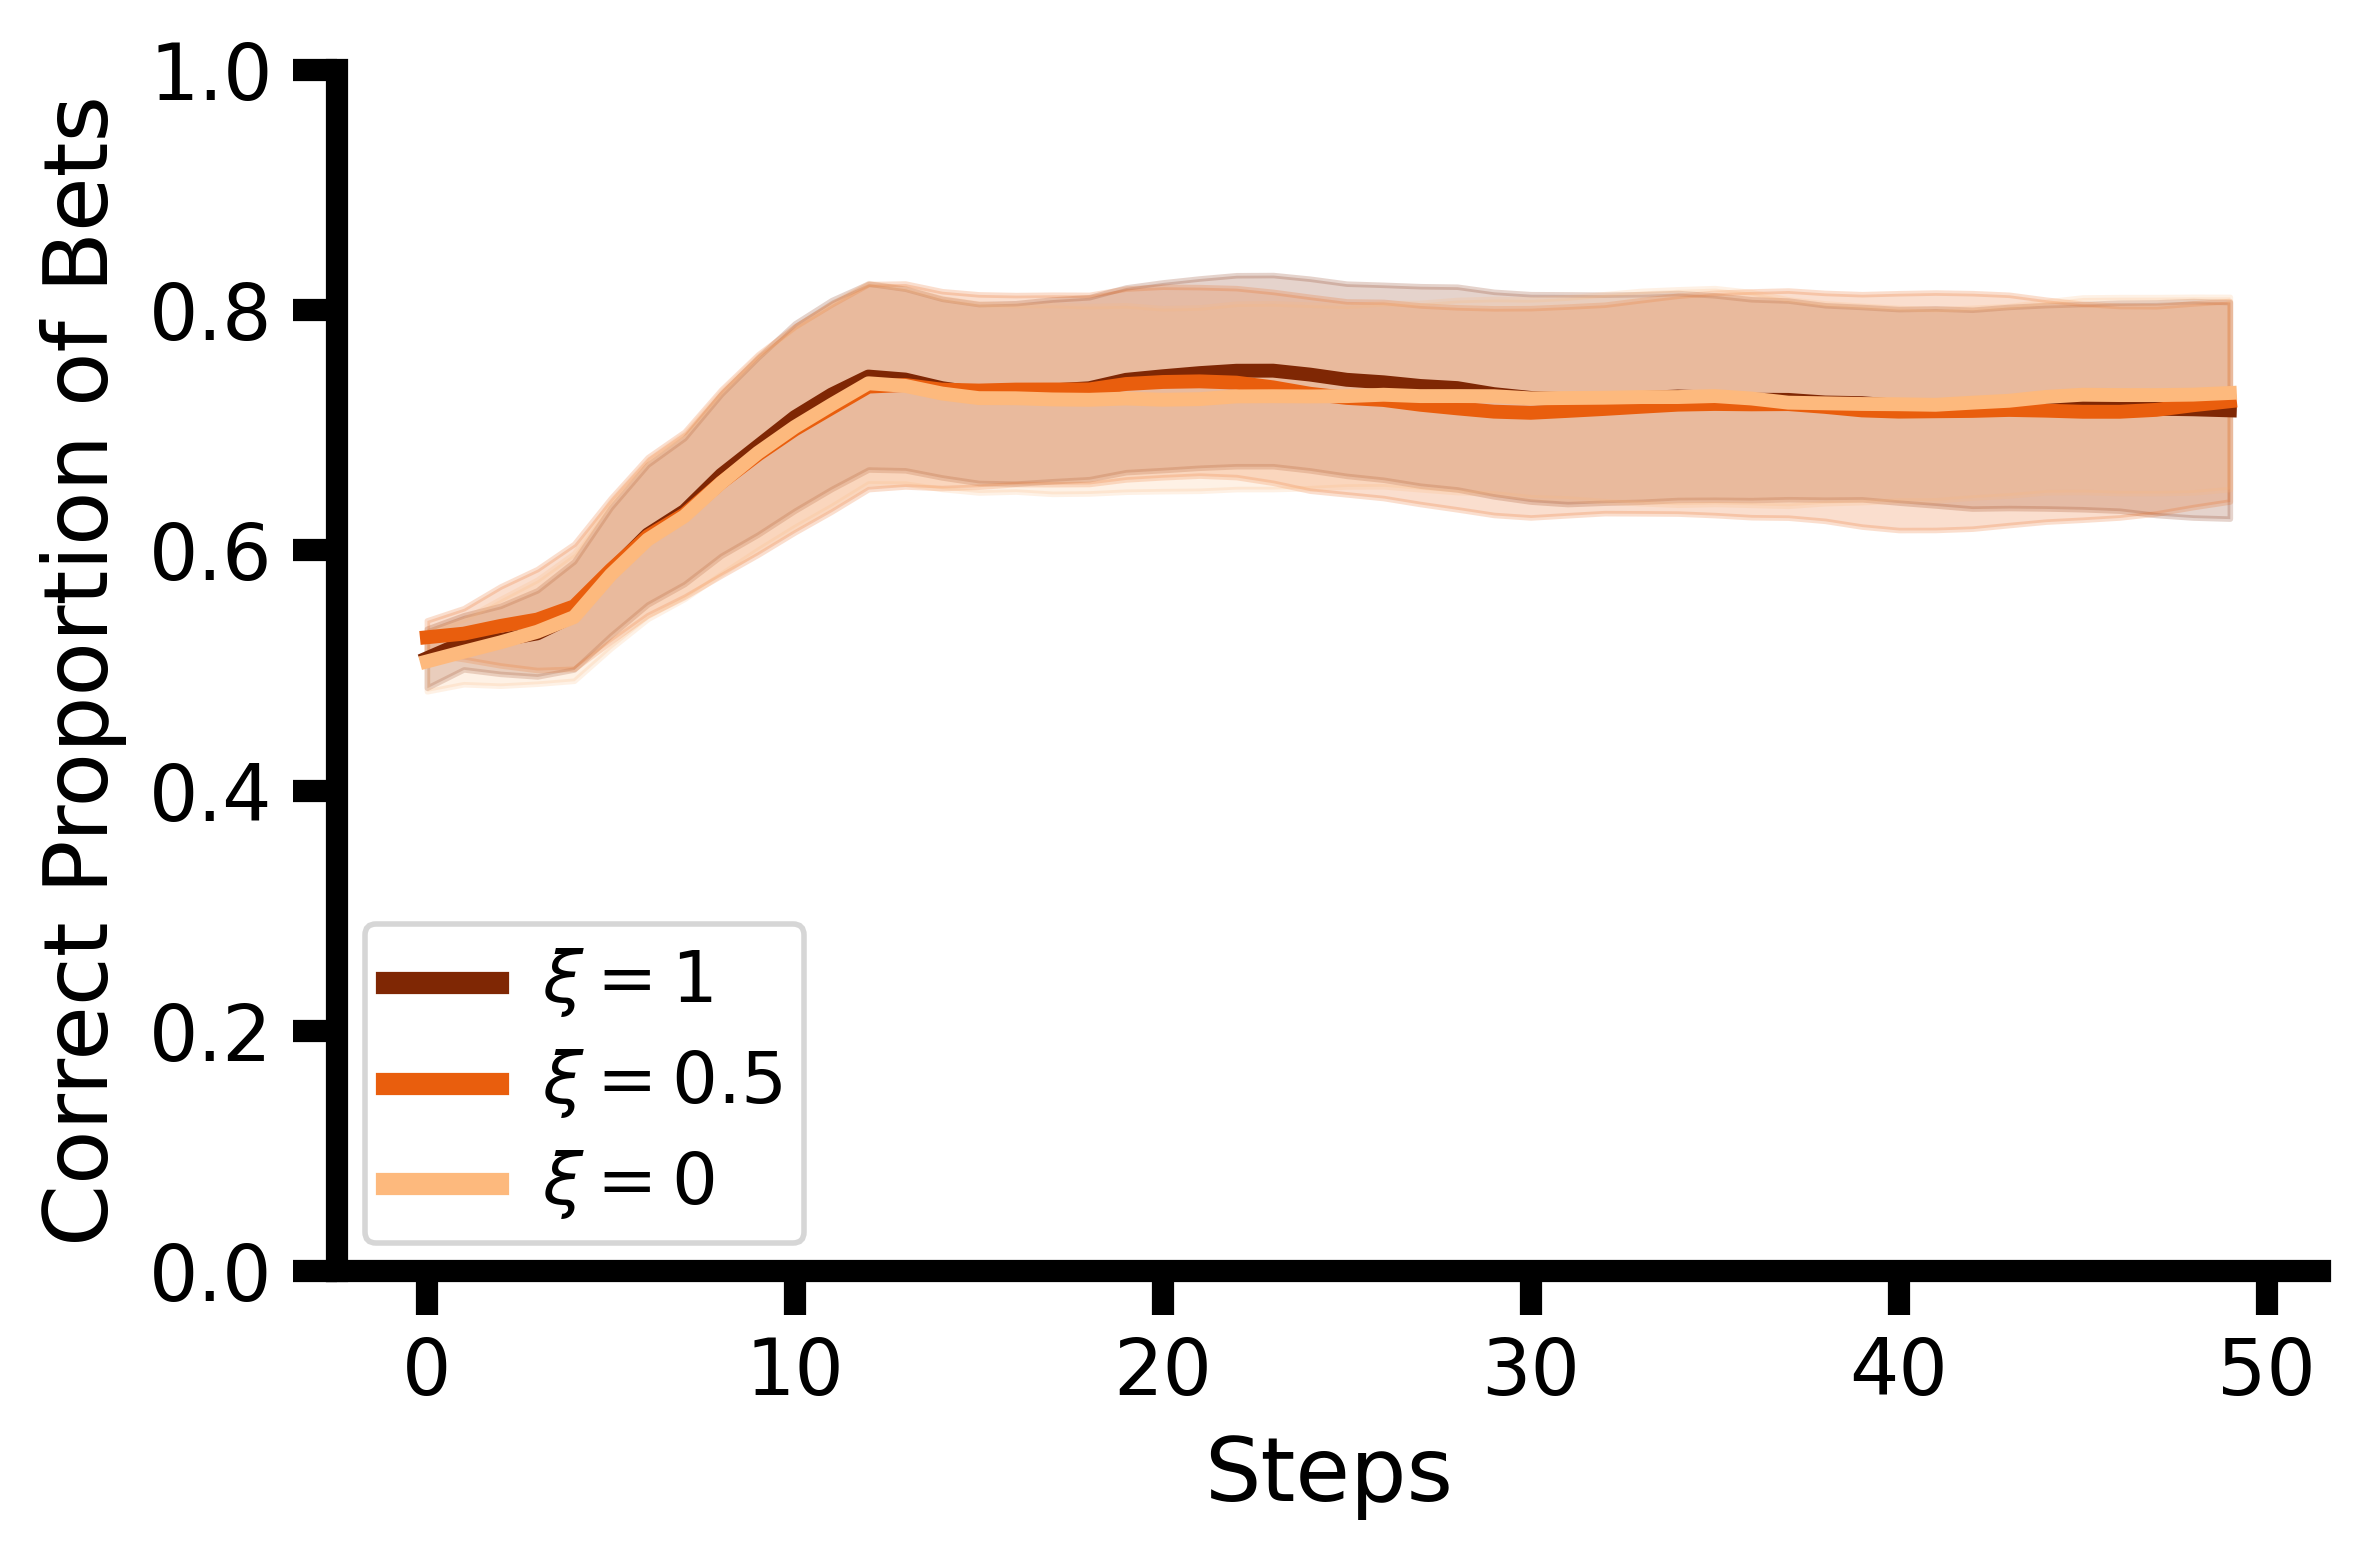

In [41]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_control, trajss_ps_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Correct Proportion of Bets", includes_sleep=True)

In [42]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noapes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noapes.svg'))

## Panel D: Across-Episode Sleeps
### General Options

In [3]:
ylim = (-1.25,25.5)

### Humans

In [4]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [5]:
n_trainA, n_testA = sort_train_test(df['n_sleeps'], df['effs'], test_start)

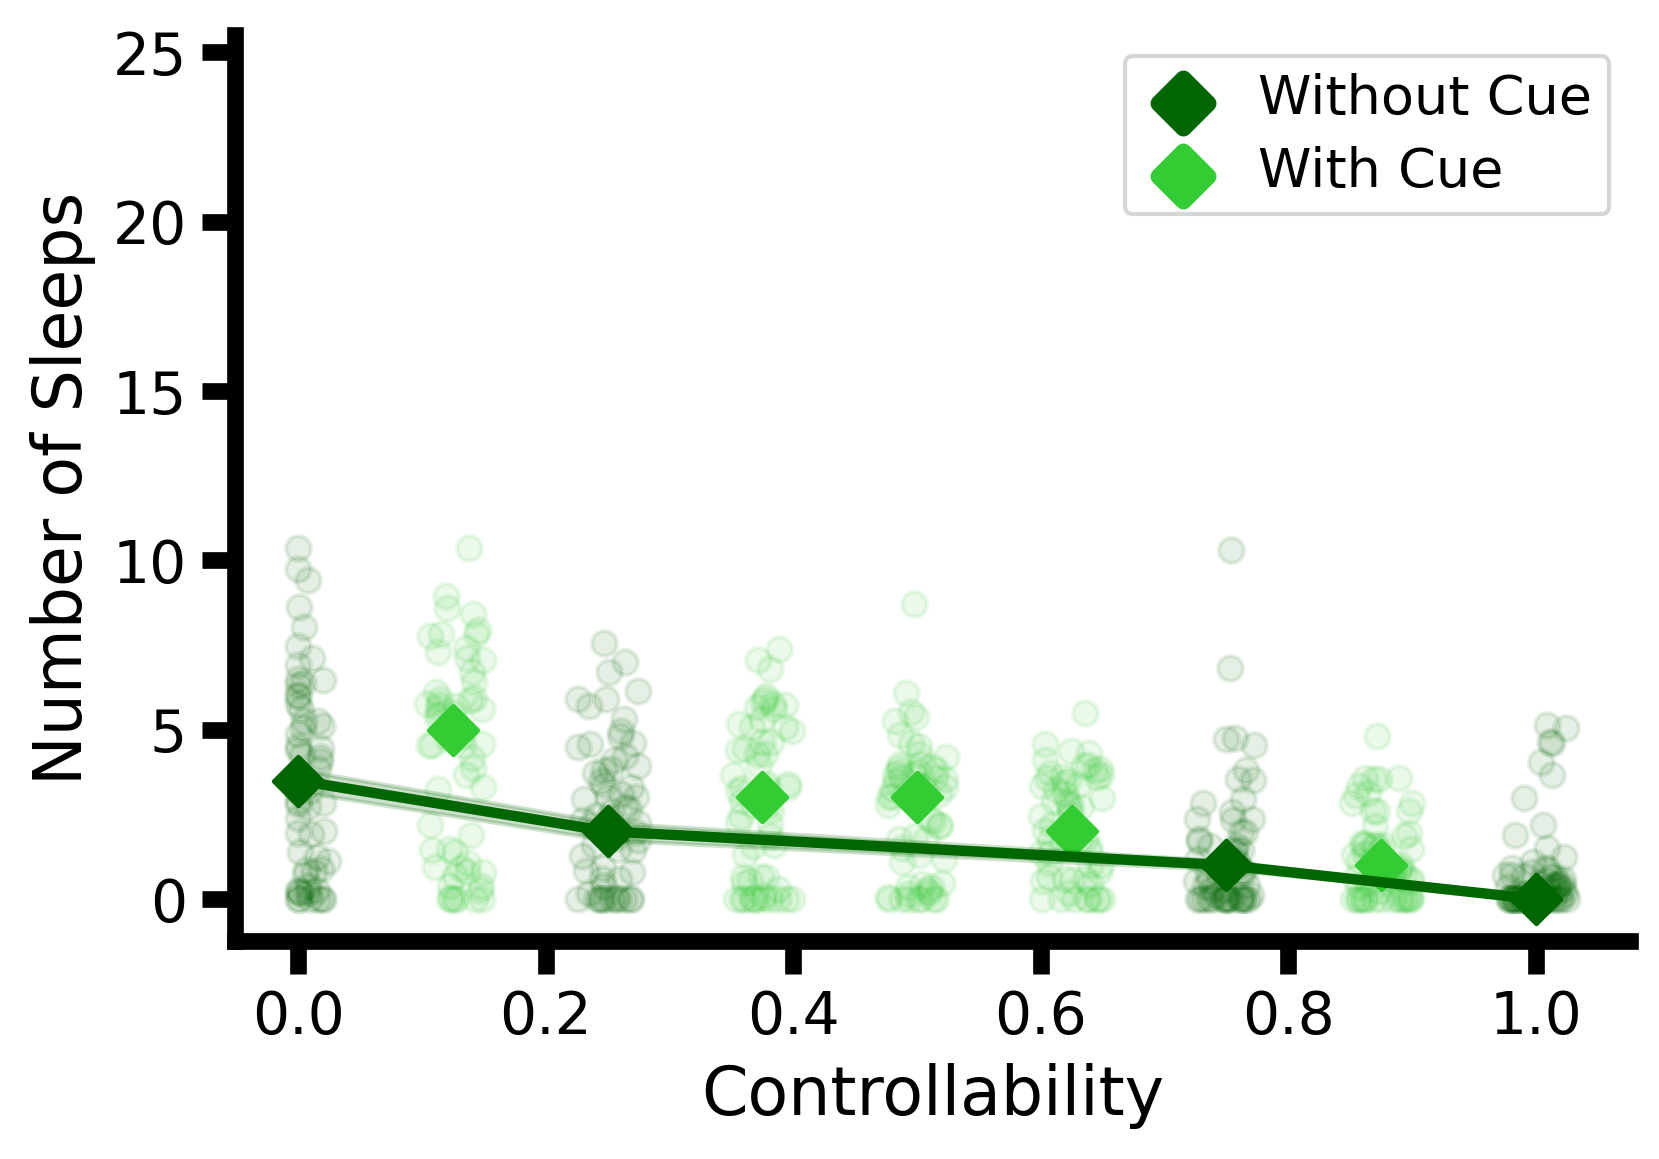

In [6]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group([n_testA], [effs_test], [n_trainA], [effs_train], ylabel='Number of Sleeps', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim)

In [7]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_humans.svg'))

### APE-trained Neural Networks

In [48]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, counterss_sleeps_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base, includes_sleep=True)


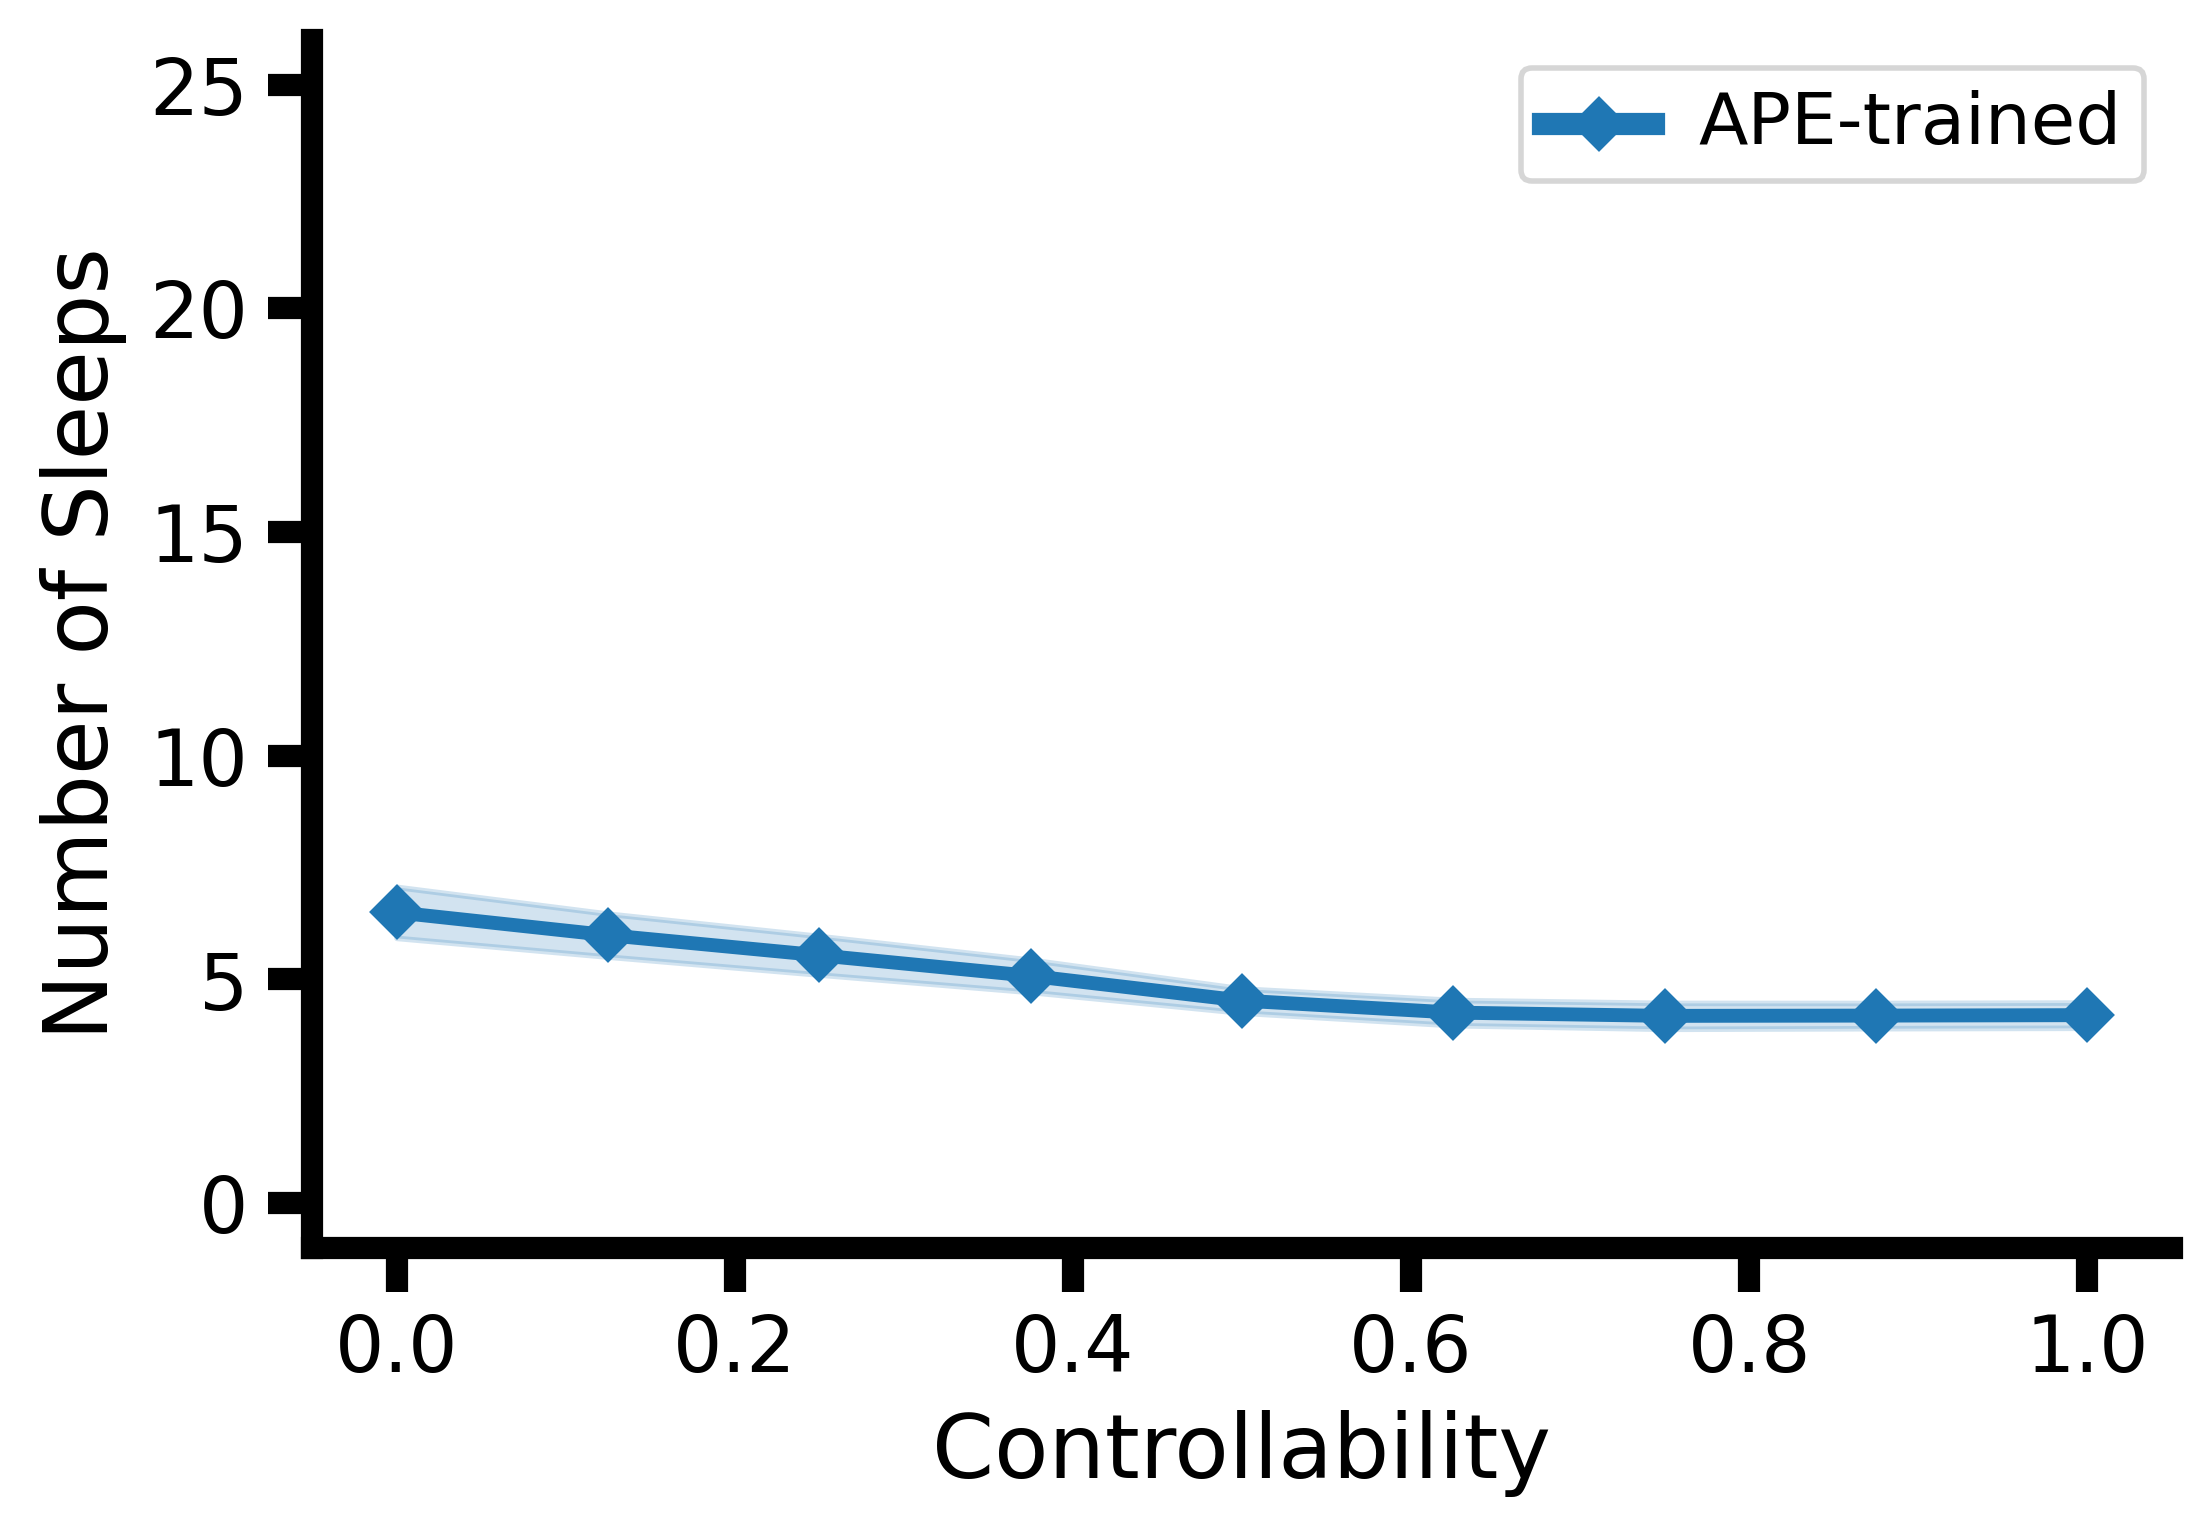

In [49]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_sleeps_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Sleeps', label_exp='APE-trained', label_control='no APE', ylim=(-1, 26), marker='D')

In [50]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_ape.svg'))

### No APE Networks

In [51]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_control, counterss_peeks_taus_control, _, counterss_sleeps_taus_control, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base, includes_sleep=True)

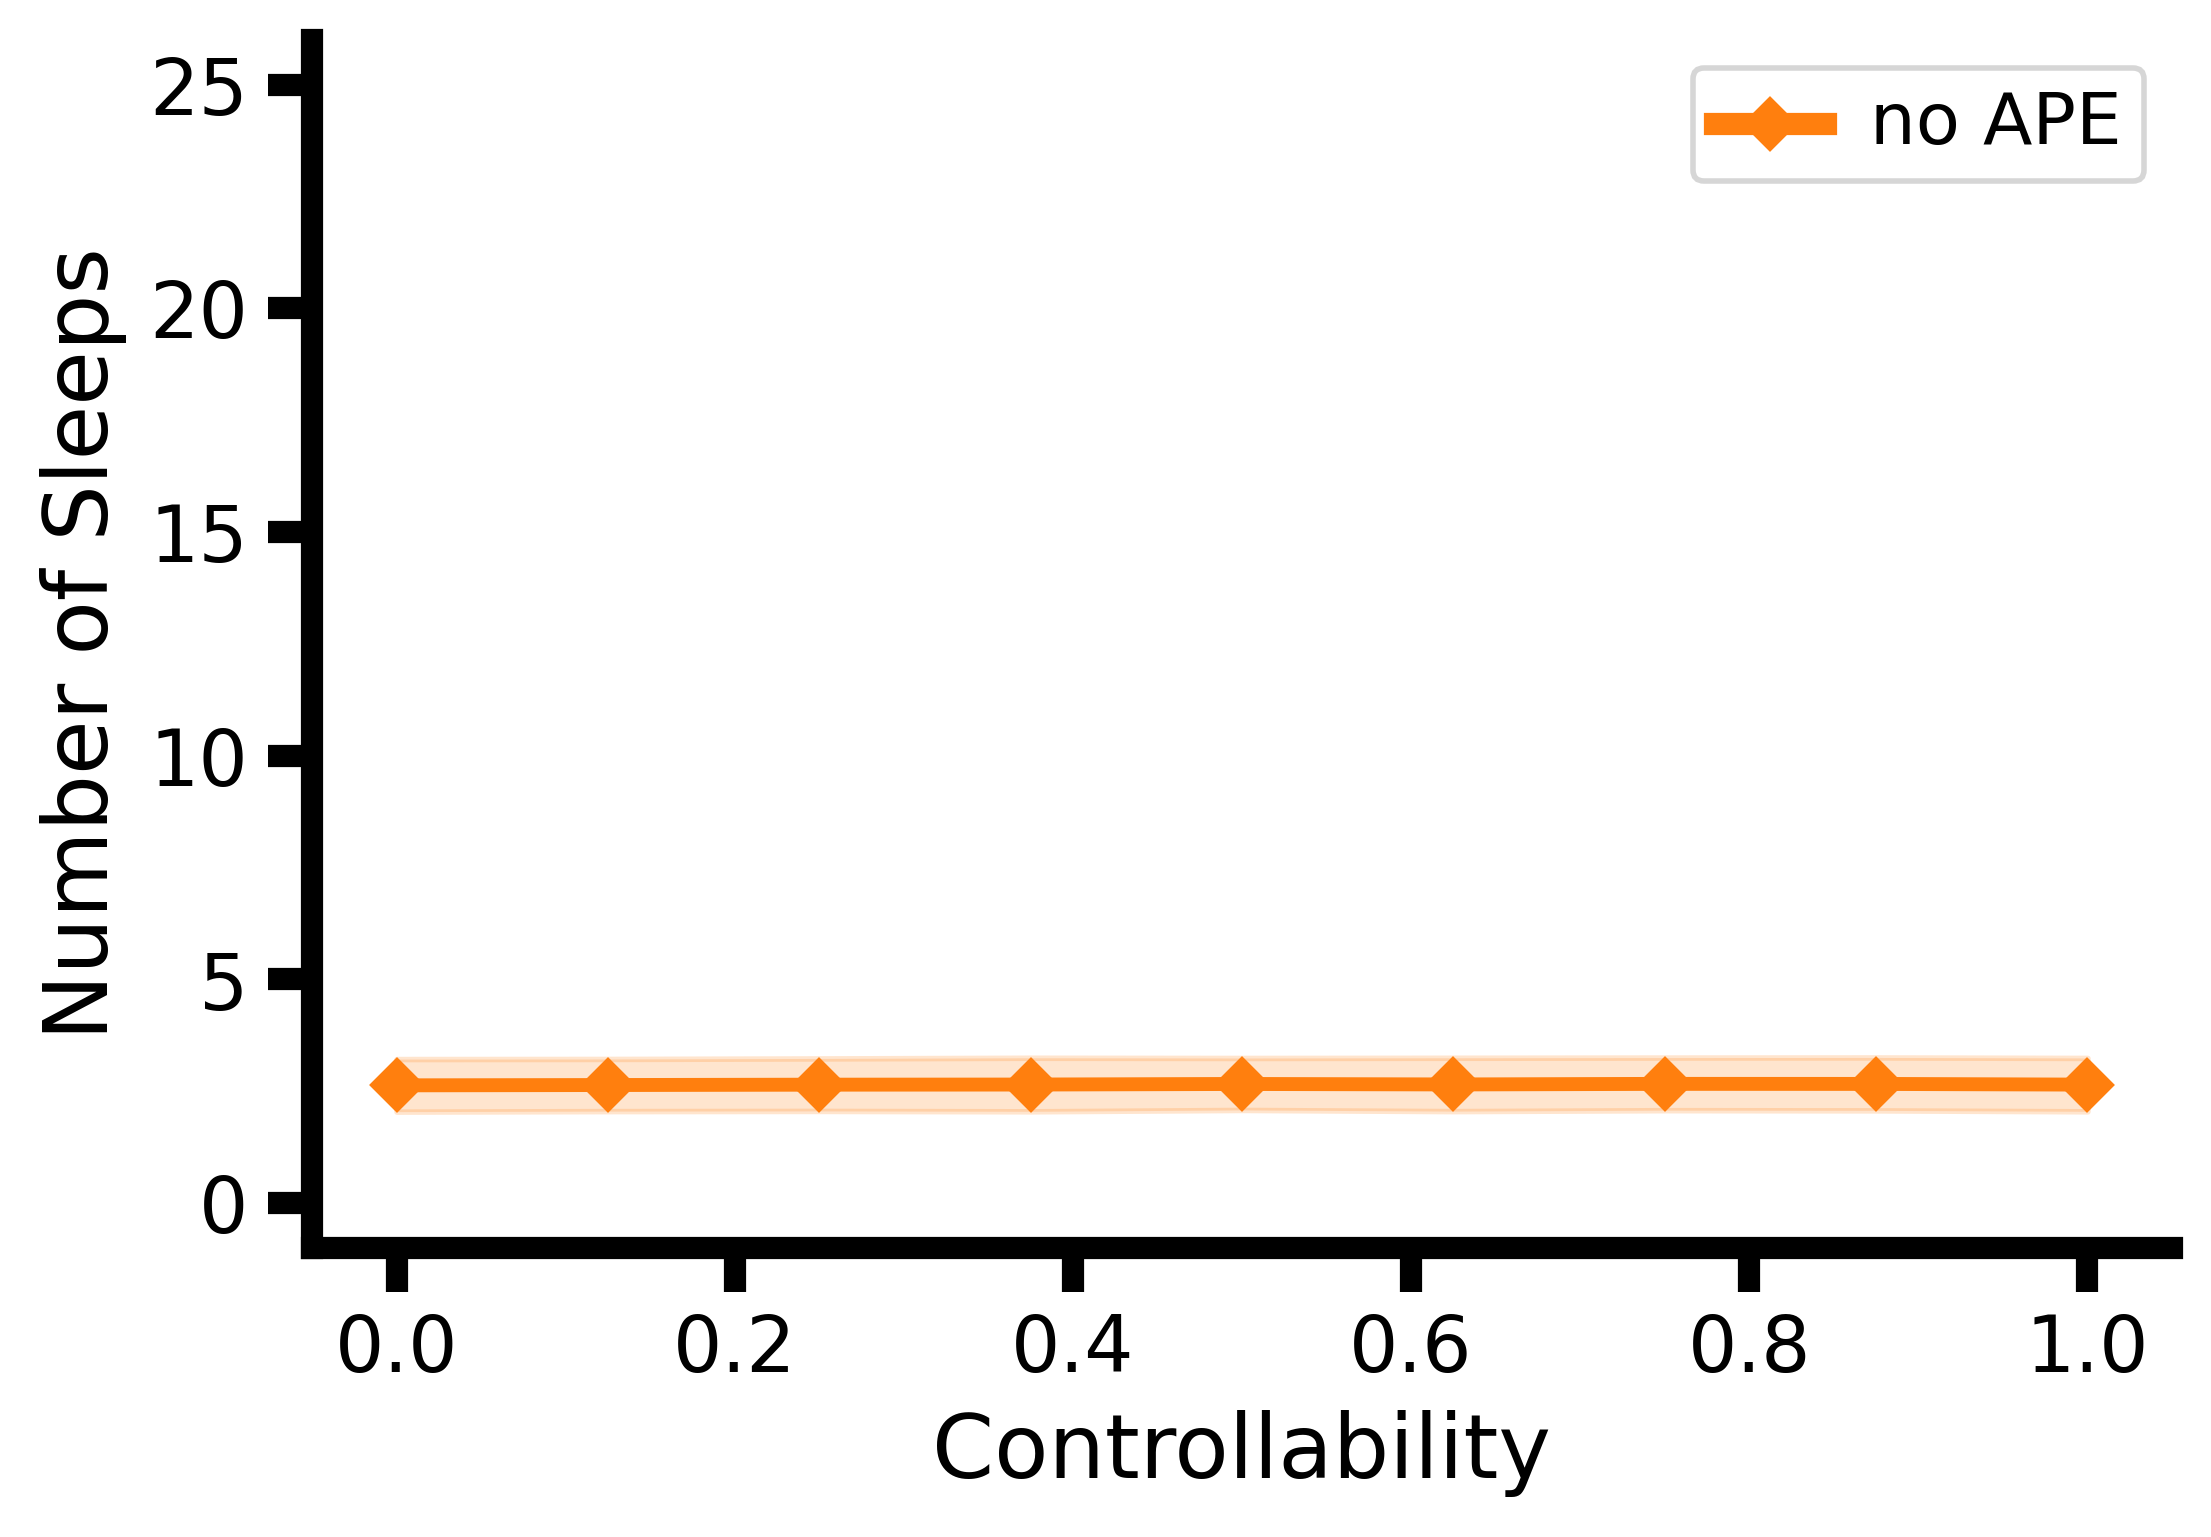

In [52]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_sleeps_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Sleeps', label_exp='APE-trained', label_control='no APE', ylim=(-1, 26), marker='D')

In [53]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_noape.svg'))

## Panel E: Across-Episode Observations
### General Options

In [8]:
ylim = (-1.25,25.5)

### Humans

In [9]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [12]:
n_trainA, n_testA = sort_train_test(df['n_observes'], df['effs'], test_start)

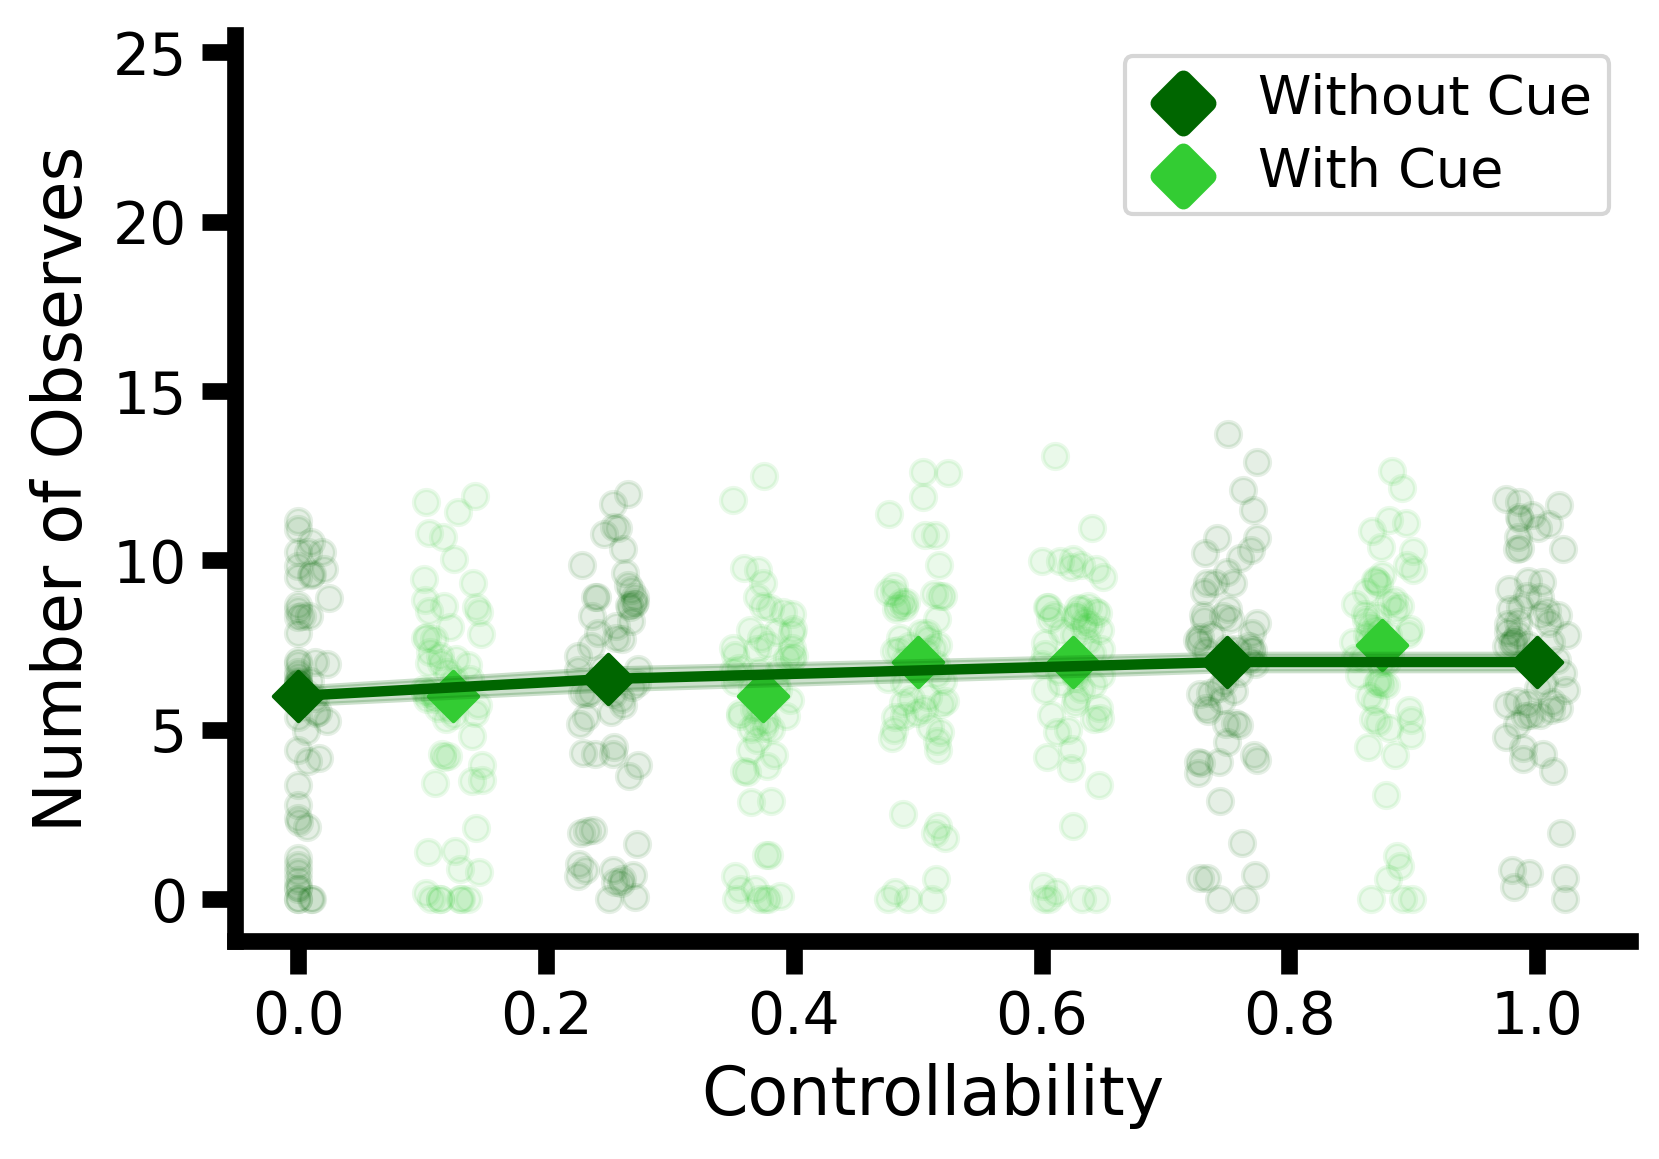

In [13]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group([n_testA], [effs_test], [n_trainA], [effs_train], ylabel='Number of Observes', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim)

In [14]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.svg'))

### APE-trained Neural Networks

In [59]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, counterss_sleeps_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base, includes_sleep=True)

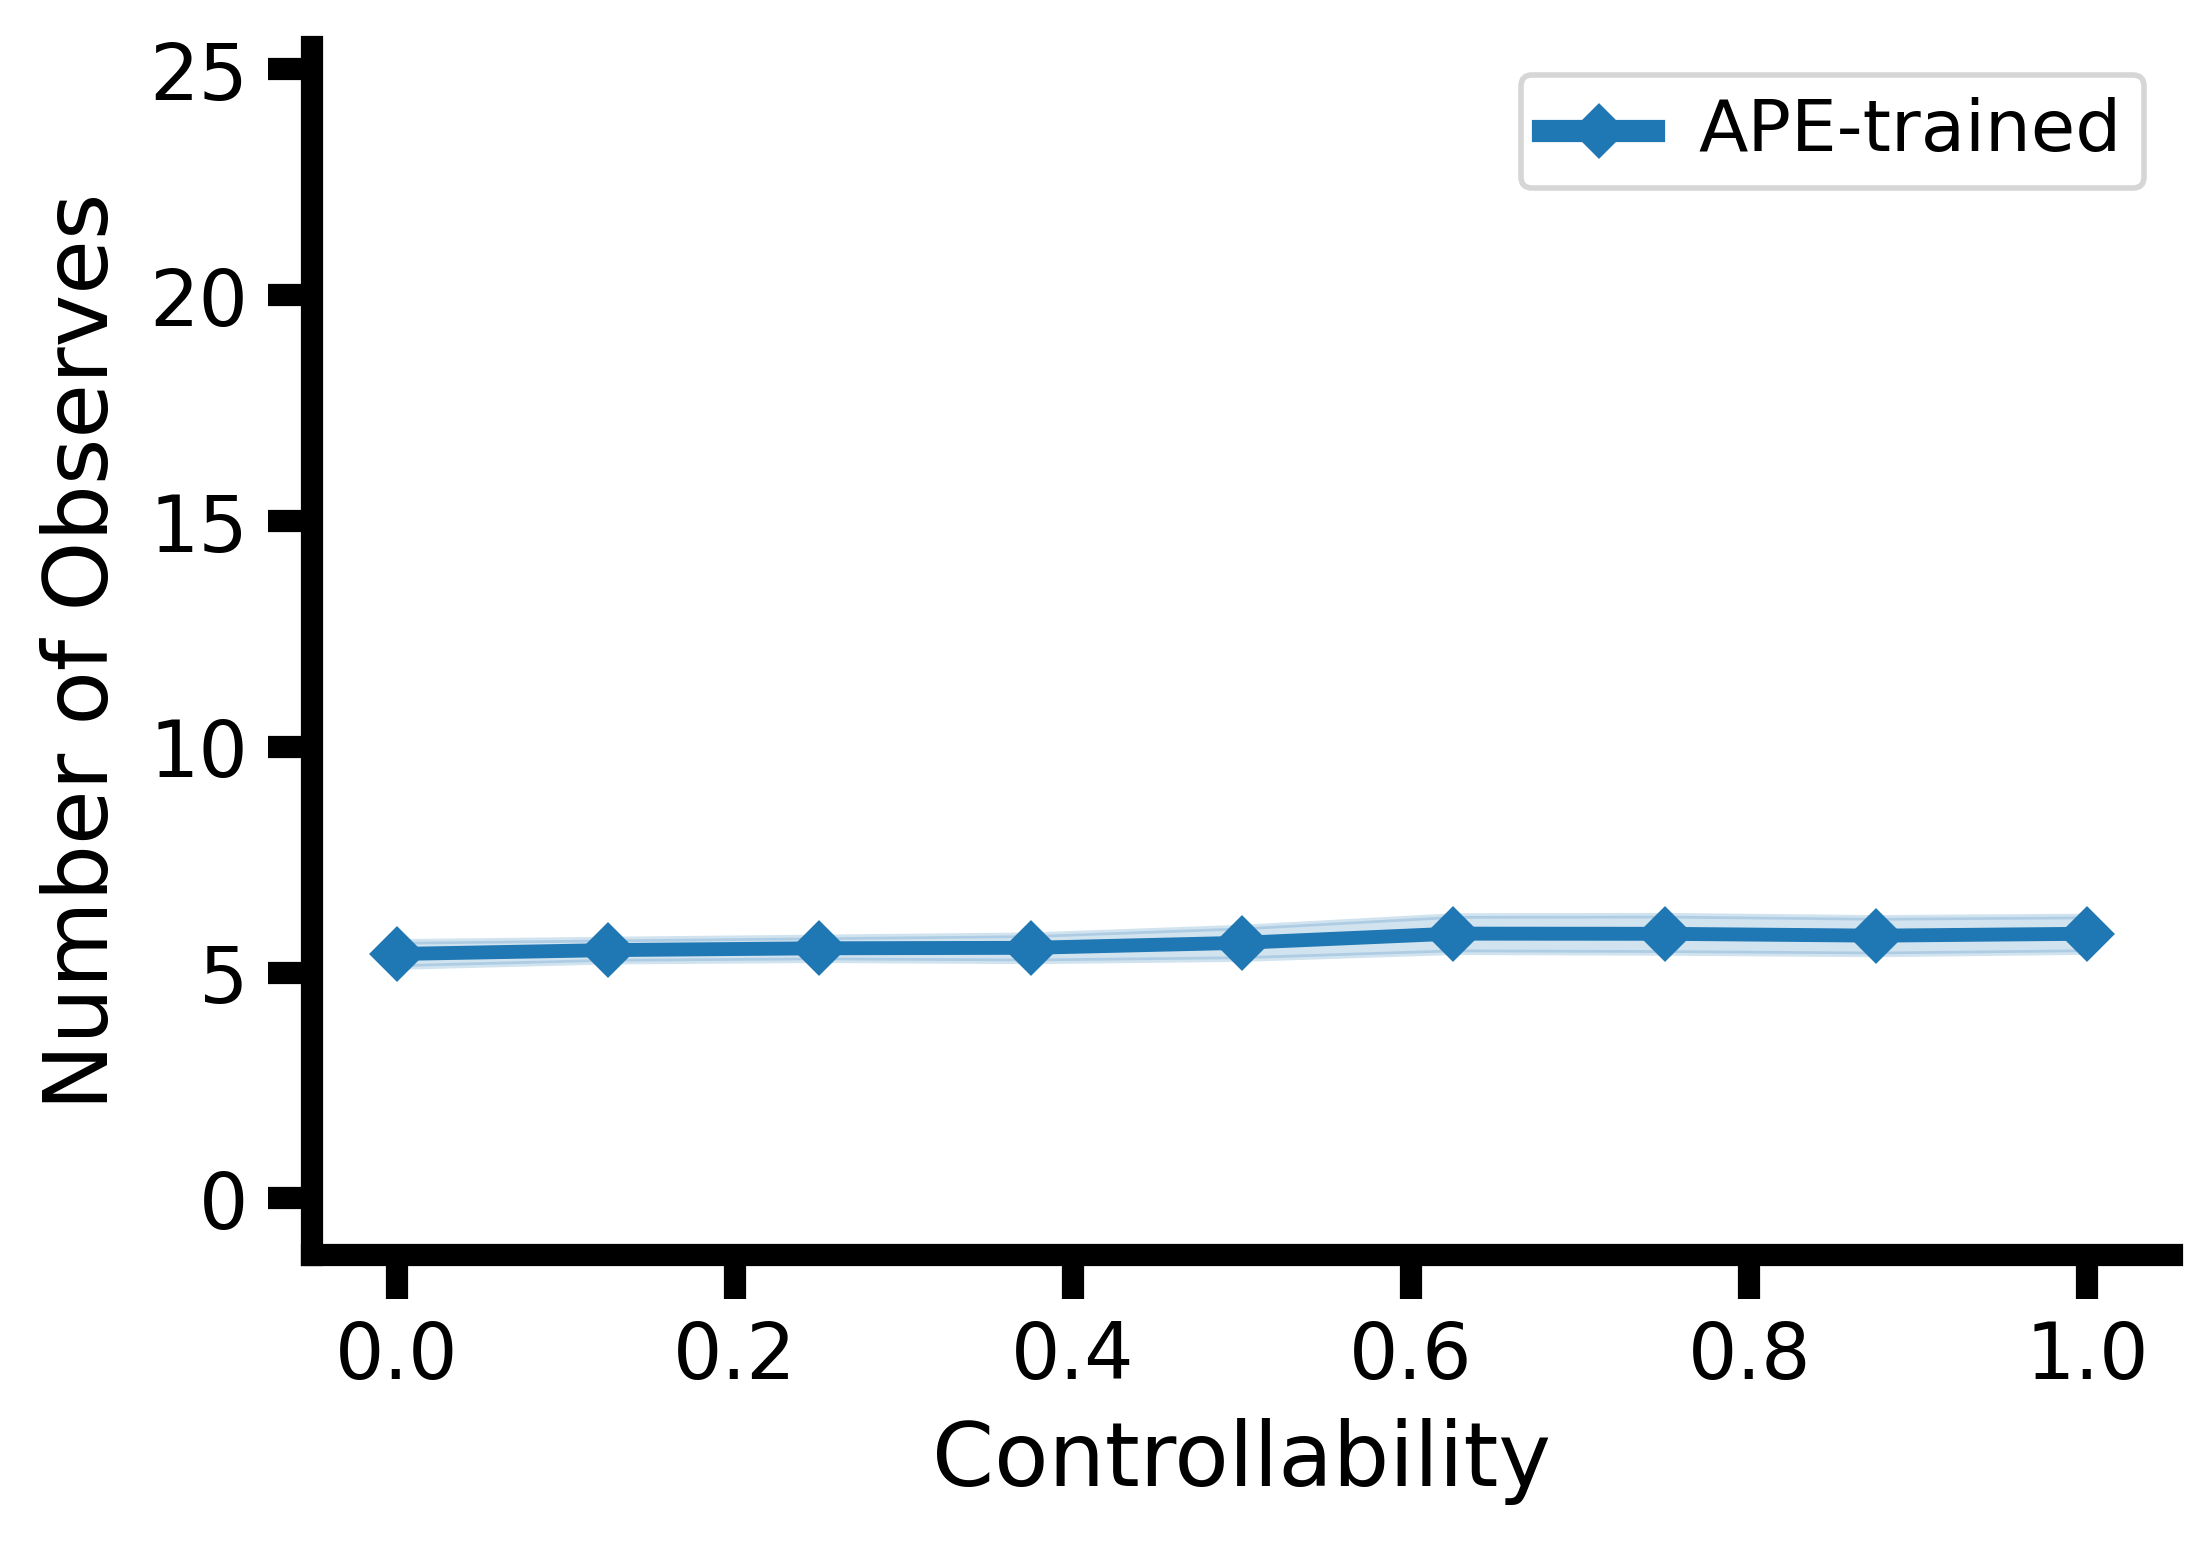

In [60]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_peeks_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [61]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.svg'))

### No APE Networks

In [62]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_control, counterss_peeks_taus_control, _, counterss_sleeps_taus_control, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base, includes_sleep=True)

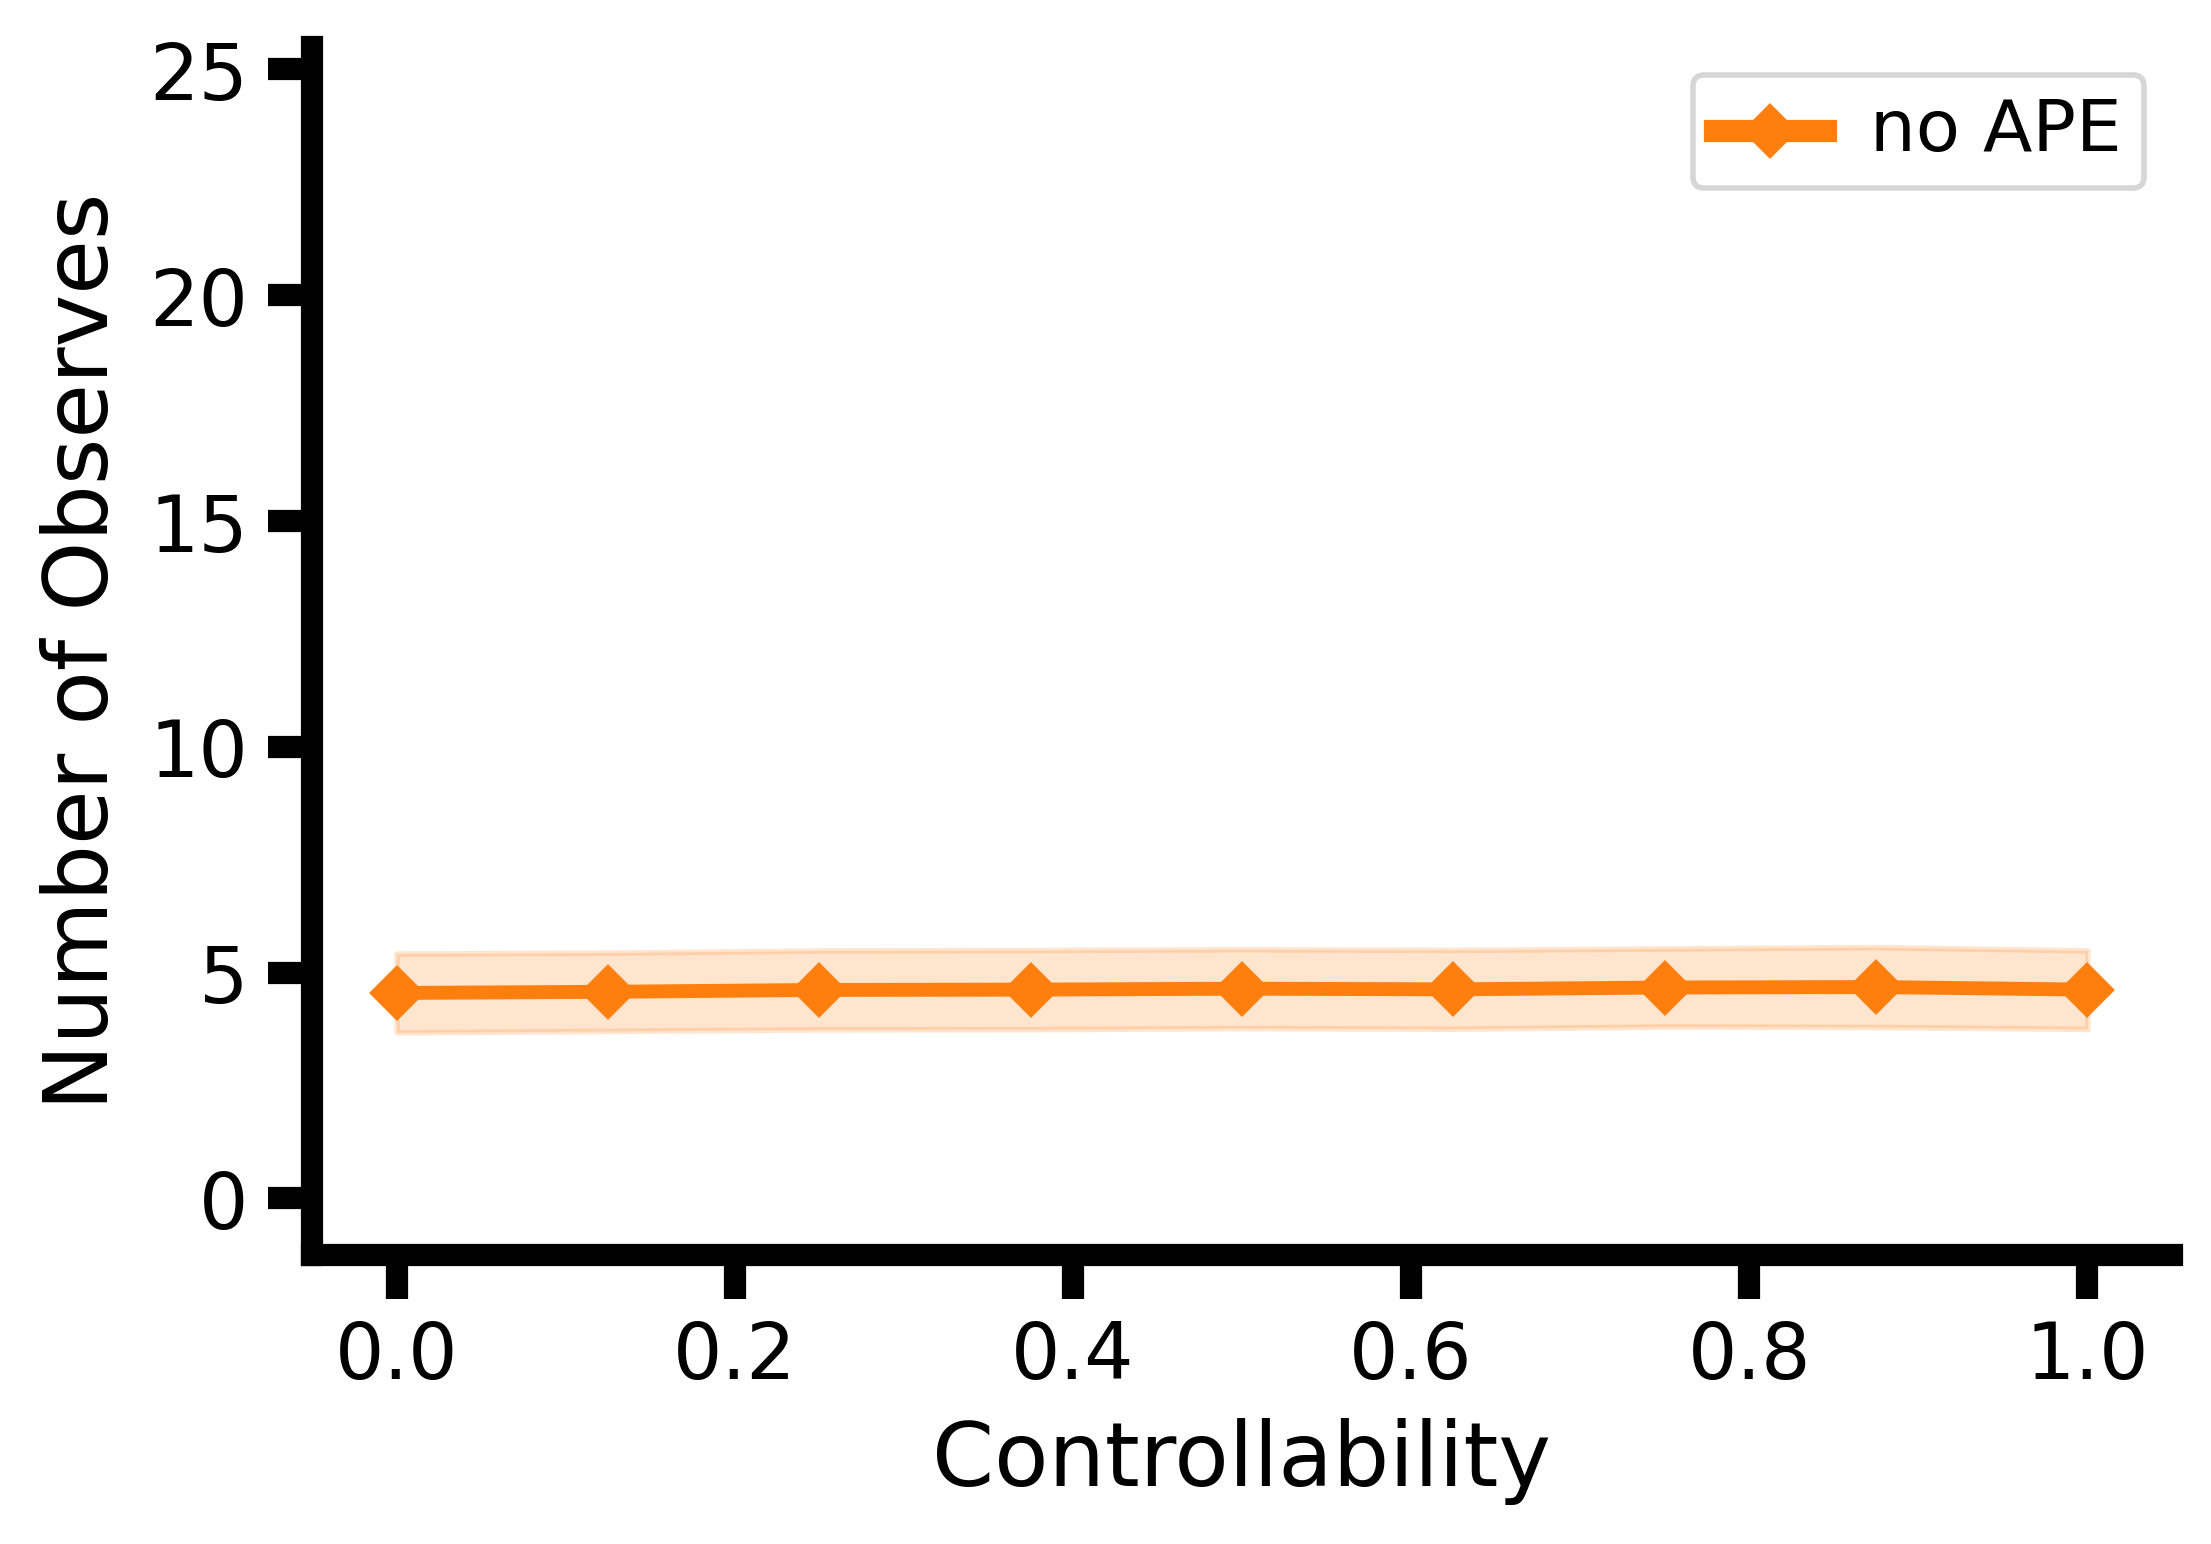

In [63]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_peeks_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [64]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.svg'))

## Panel F: Rewards
### General Options

In [15]:
ylim= (-1, 49)

### Humans

In [16]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [18]:
n_trainA, n_testA = sort_train_test(df['rewards_tallies'], df['effs'], test_start)

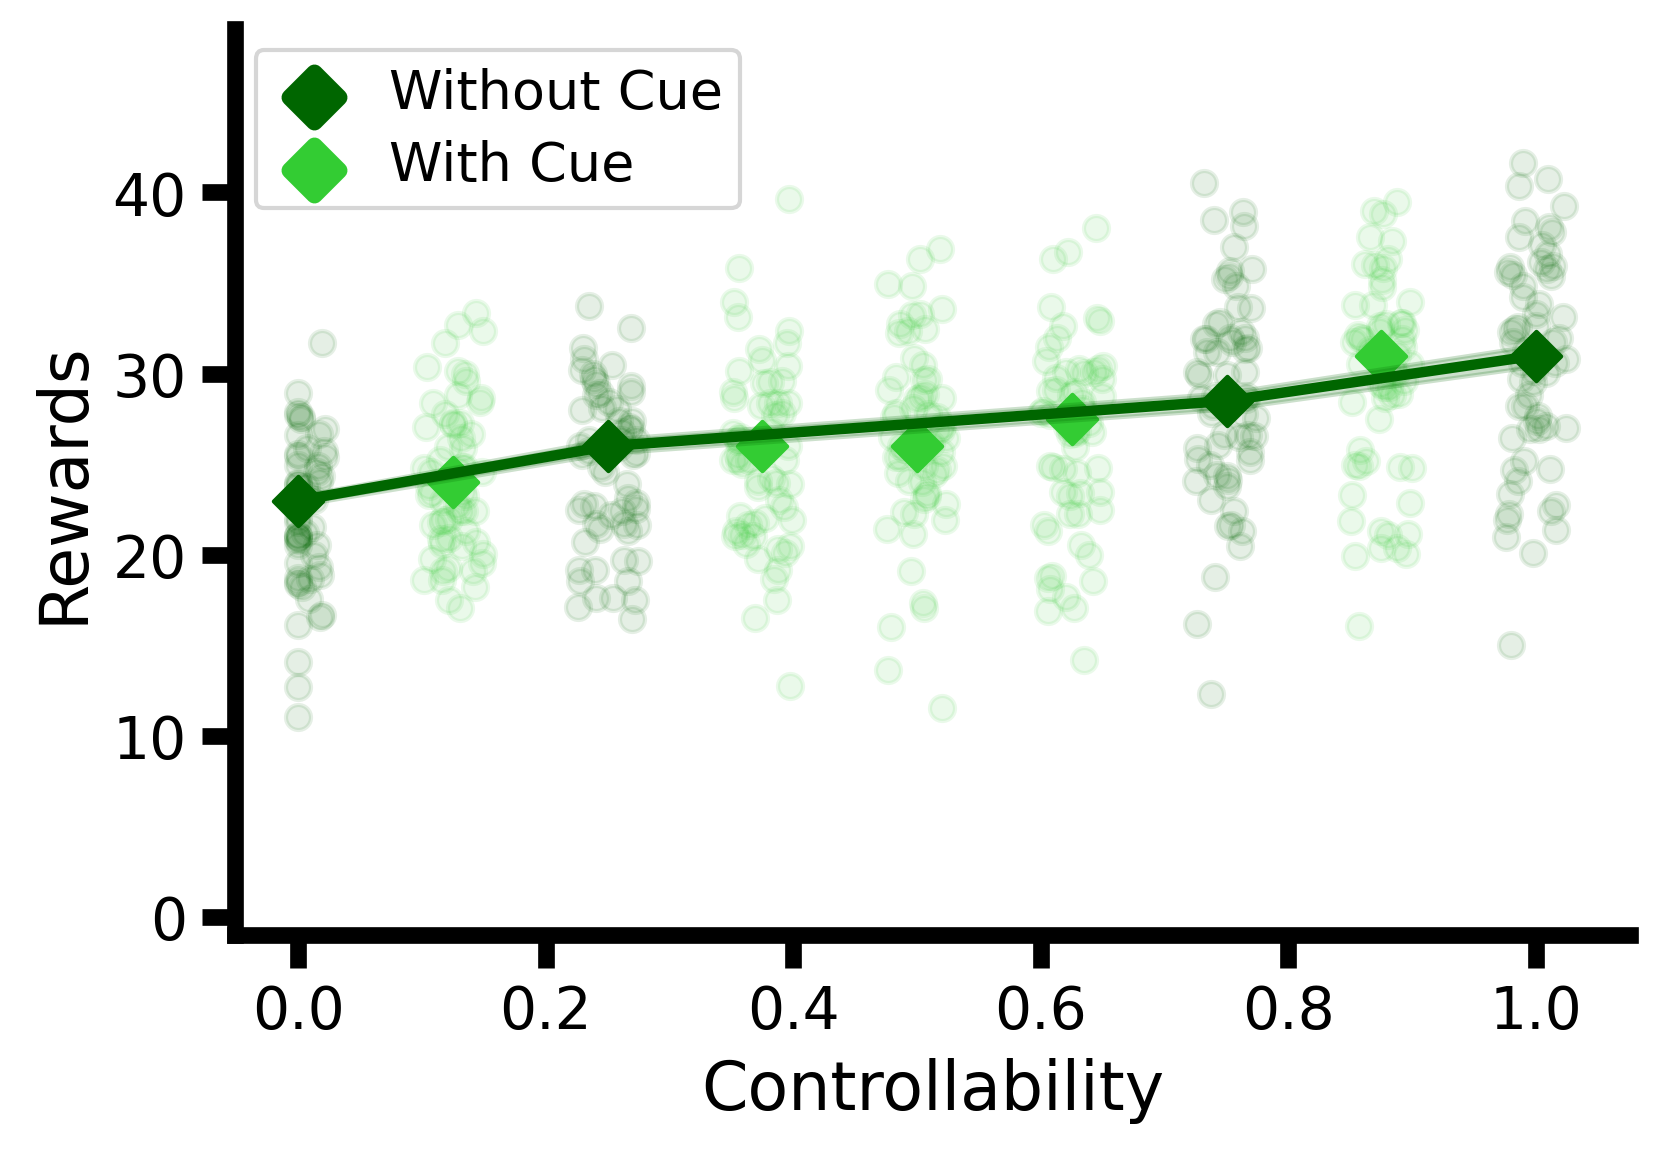

In [19]:
from human_plot_traj_analyses import plot_line_scatter_group

fig = plot_line_scatter_group([n_testA], [effs_test], [n_trainA], [effs_train], ylabel='Rewards', ylim=ylim, xjitter=0.025, yjitter=1, median_over_mean=True,)

In [20]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.svg'))

#### Stats

In [70]:
selected_rewards_tallies = [n_testA[:,-1], n_testB[:,2], n_testA[:,0]]

In [71]:
## MEANS AND SEMS
for level, rewards in zip(plotted_levels, selected_rewards_tallies):
    print("Test Controllability ", level)
    print("Mean ", rewards.mean())
    print("StdErr ", rewards.std()/np.sqrt(rewards.shape[0]))
    print("N", rewards.shape[0])

Test Controllability  1
Mean  33.82608695652174
StdErr  0.8482743228860326
N 46
Test Controllability  0.5
Mean  26.70769230769231
StdErr  0.6899869056035883
N 65
Test Controllability  0
Mean  24.02173913043478
StdErr  0.5820967335557214
N 46


In [72]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, selected_rewards_tallies)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(selected_rewards_tallies), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    0.5    2.686 0.0238 0.2902 5.0817   True
   0.0    1.0   9.8043    0.0 7.2117 12.397   True
   0.5    1.0   7.1184    0.0 4.7227 9.5141   True
--------------------------------------------------


In [73]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'rewards_tallies')
glm.summary()


/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:              MixedLM  Dependent Variable:  rewards_tallies
No. Observations:   999      Method:              REML           
No. Groups:         111      Scale:               32.1985        
Min. group size:    9        Log-Likelihood:      -3188.5695     
Max. group size:    9        Converged:           Yes            
Mean group size:    9.0                                          
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              24.761    0.658 37.602 0.000 23.470 26.051
C(efficacy_C)[T.0.125]  0.604    0.762  0.792 0.428 -0.889  2.096
C(efficacy_C)[T.0.25]   0.838    0.762  1.100 0.271 -0.655  2.331
C(efficacy_C)[T.0.375]  3.486    0.762  4.577 0.000  1.994  4.979
C(efficacy_C)[T.0.5]    3.495    0.762  4.589 0.000  2.003  4.988
C(efficacy_C)[T.0.625]  5.396    0.762  7.085 0.000  3.904  6.889
C(efficacy_C)[T.0.75]   6.351    0.762  8.339 0.000  4.858  7.844
C(efficacy_C)[T.0.875]  8.297    0.762 10.893 0.000  6.804  9.790
C(efficacy_C)[T.1.0]    8.838    0.762 11.603 0.000  7.345 10.331
C(group_C)[T.True]     -1.376    0.548 -2.511 0.012 -2.450 -0.302
Group Var               4.508    0.212                           
=================================================================

"""

### APE-trained Neural Networks

In [74]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, counterss_sleeps_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base, includes_sleep=True)

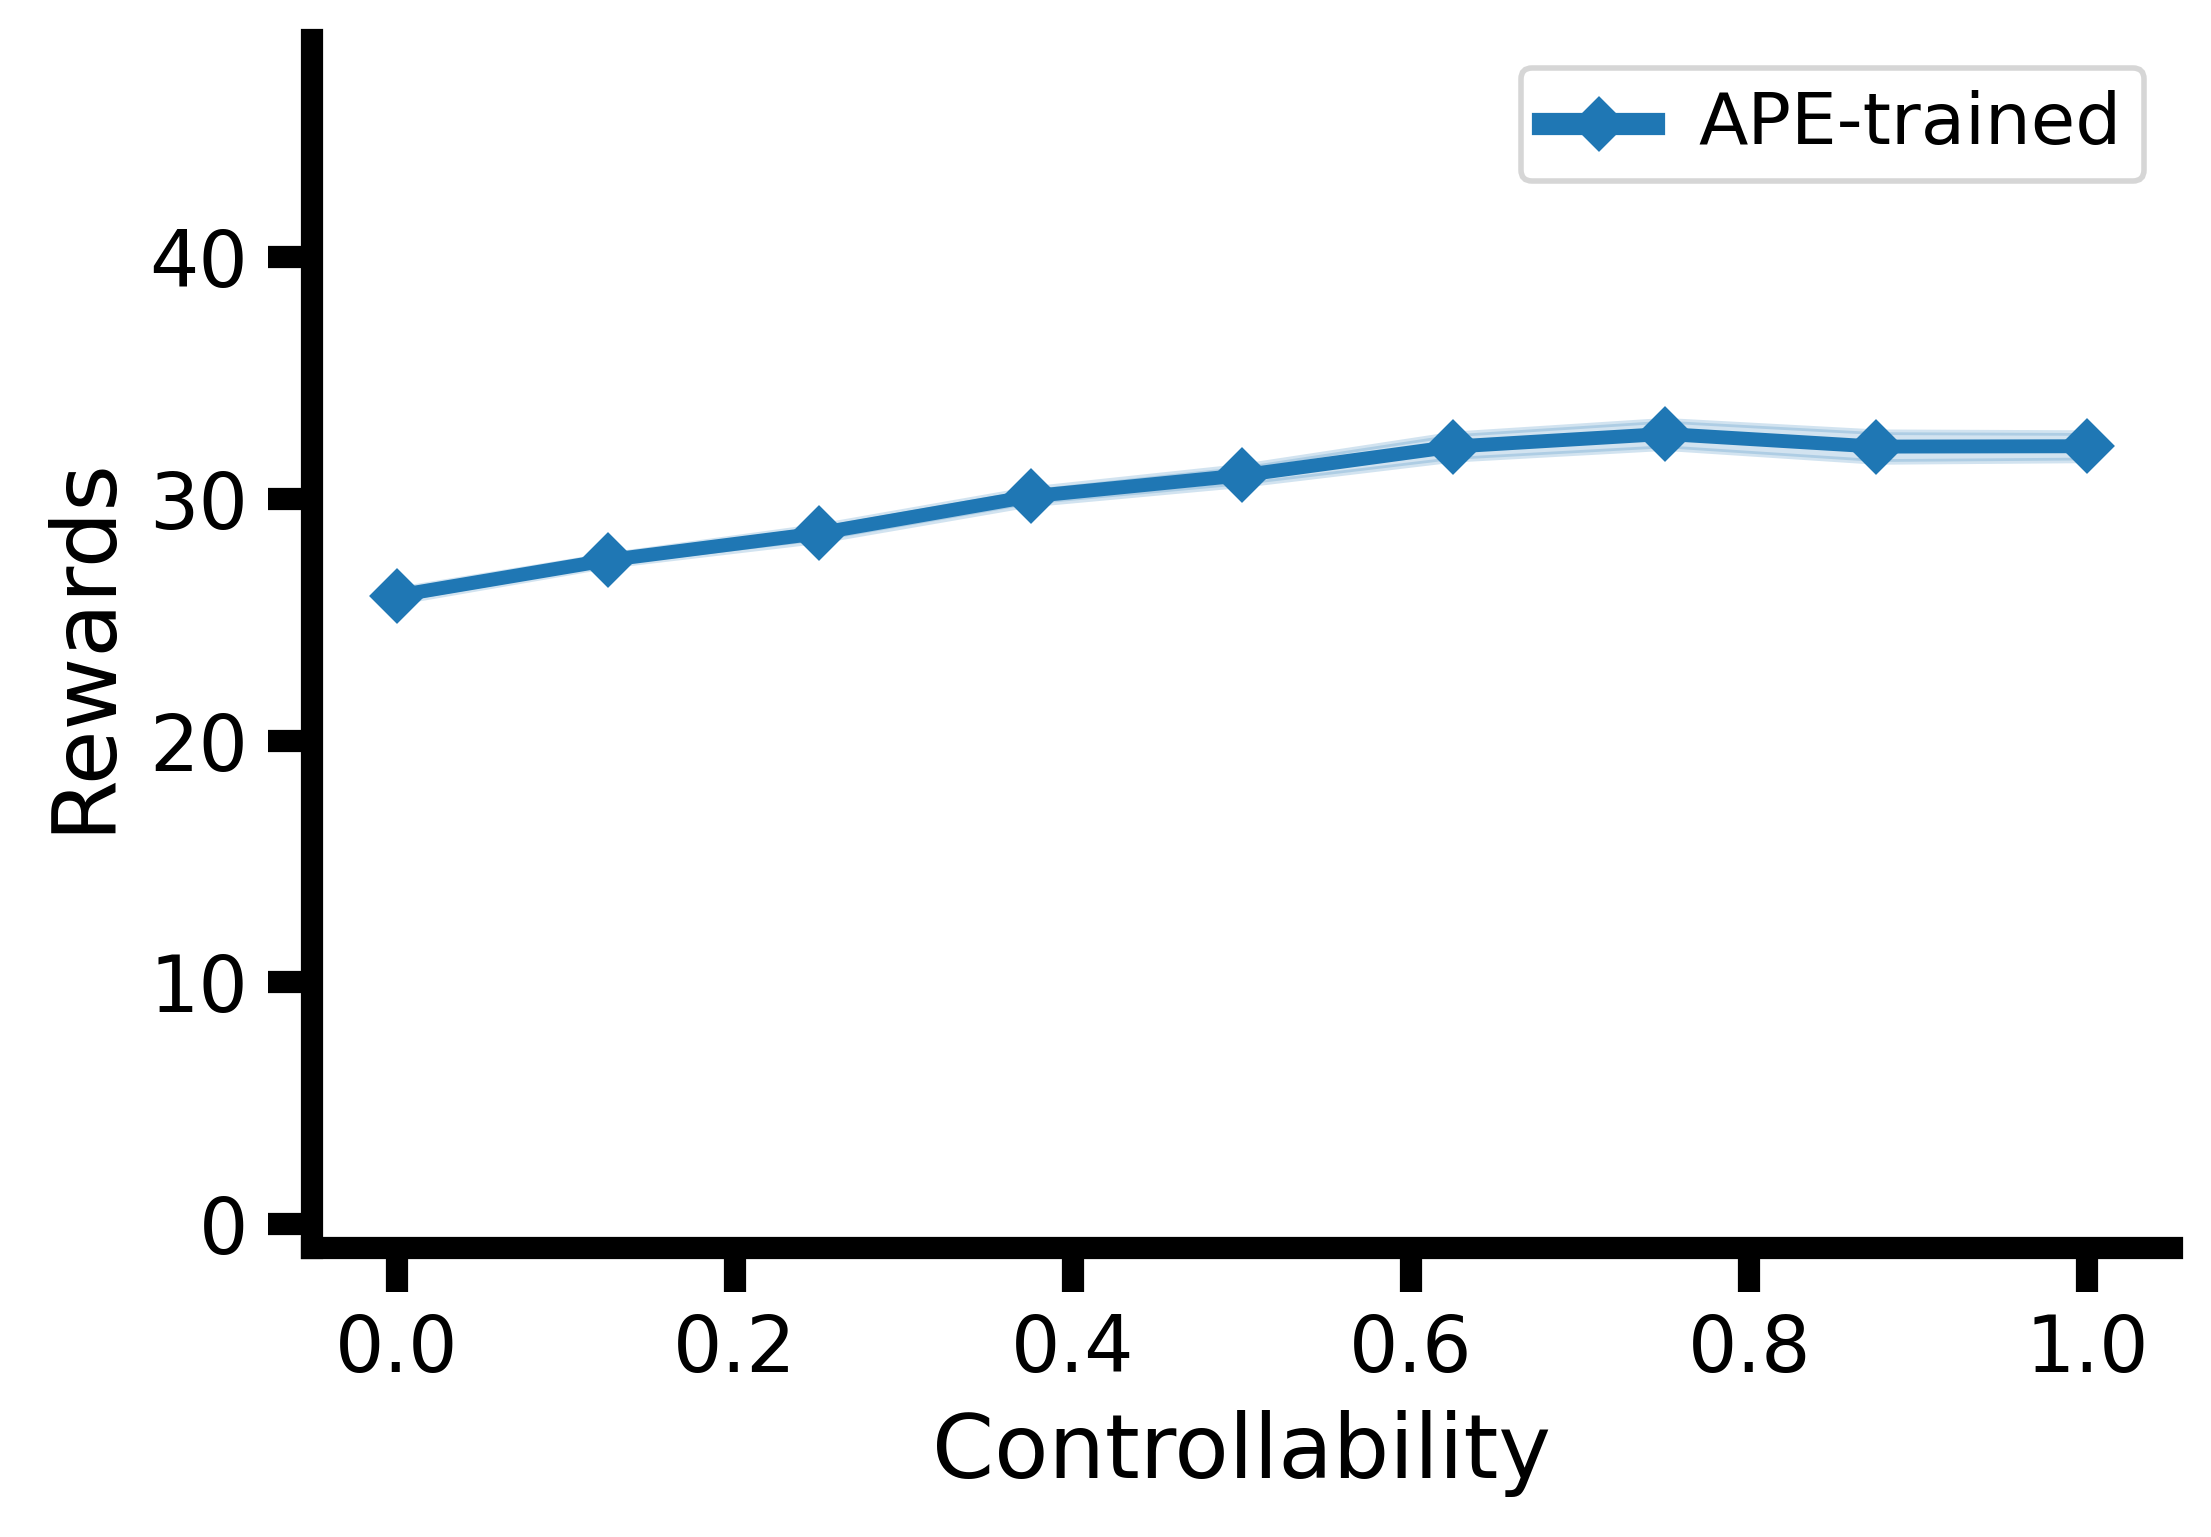

In [75]:
fig = plot_comparison_curves_several_runs(test_taus, list(reversed(rewss_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_exp='APE-trained', ylim=ylim, marker='D')

In [76]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.svg'))

### No APE Neural Networks

In [77]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_control, counterss_peeks_taus_control, _, counterss_sleeps_taus_control, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base, includes_sleep=True)

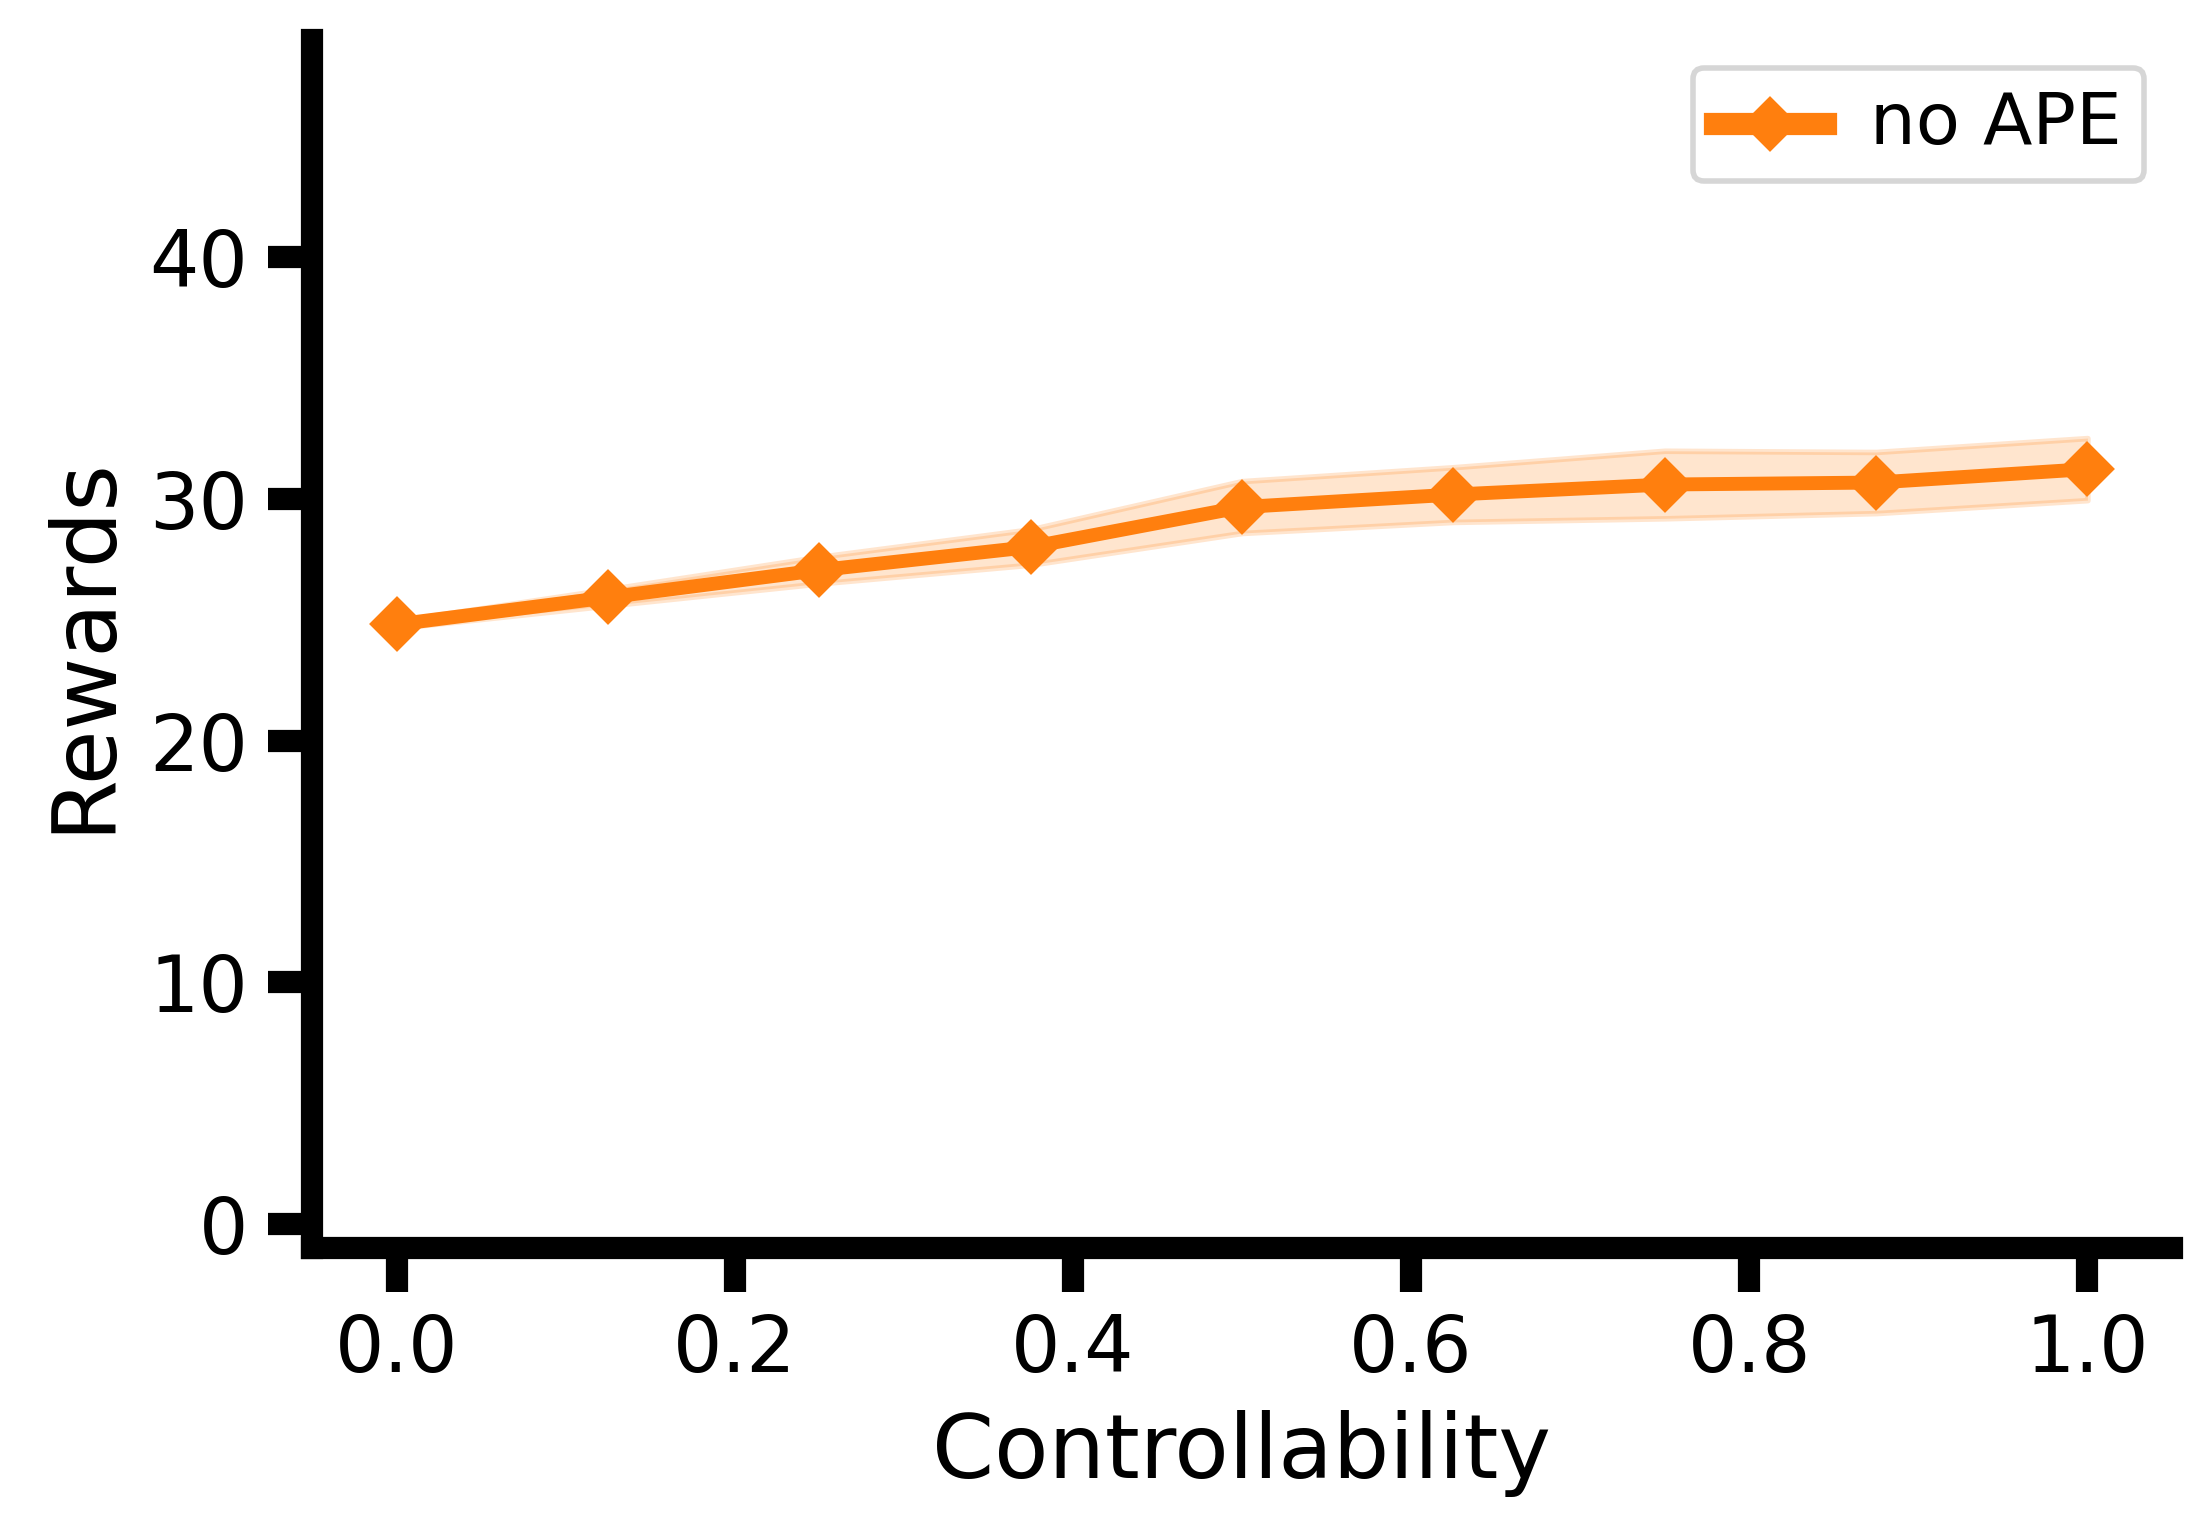

In [78]:
fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(rewss_taus_control)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_control='no APE', ylim=ylim, marker='D')

In [79]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.svg'))

## Stats Likelihood

In [82]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [83]:
df_file_A_22 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527162546_behavior_diff_effs_24-01-22_day3_with_nets_groupA.pkl'
df_file_B_22 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527163117_behavior_diff_effs_24-01-22_day3B_with_nets_groupB.pkl'

df_file_A_29 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527164255_behavior_diff_effs_24-01-29_day3_with_nets_groupA.pkl'
df_file_B_29 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527164833_behavior_diff_effs_24-01-29_day3B_with_nets_groupB.pkl'

df_A = pd.read_pickle(df_file_A_22)
df_B = pd.read_pickle(df_file_B_22) 

df_A_29 = pd.read_pickle(df_file_A_29)
df_B_29 = pd.read_pickle(df_file_B_29)

df_A = pd.concat([df_A, df_A_29])
df_B = pd.concat([df_B, df_B_29])

## only keep the rows in df_A that match an index in df (keeping in mind there might be missing keys)
df_A = df_A[df_A.index.isin(df.index)]
df_B = df_B[df_B.index.isin(df.index)]

In [85]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import levc_human_control_models as control_models
from human_utils_project import sort_train_test


test_liks_A_ape = []
test_liks_A_noape = []
test_liks_B_ape = []
test_liks_B_noape = []

for model in ape_models:
    train_liks_A, test_liks_A = sort_train_test(df_A['step_l_%d' %model], df_A['effs'], test_start=5)
    test_liks_A_ape.append(test_liks_A)

for model in control_models:
    train_liks_A, test_liks_A = sort_train_test(df_A['step_l_%d' %model], df_A['effs'], test_start=5)
    test_liks_A_noape.append(test_liks_A)

for model in ape_models:
    train_liks_B, test_liks_B = sort_train_test(df_B['step_l_%d' %model], df_B['effs'], test_start=5)
    test_liks_B_ape.append(test_liks_B)

for model in control_models:
    train_liks_B, test_liks_B = sort_train_test(df_B['step_l_%d' %model], df_B['effs'], test_start=5)
    test_liks_B_noape.append(test_liks_B)

test_liks_A_ape = np.array(test_liks_A_ape)
test_liks_A_noape = np.array(test_liks_A_noape)
test_liks_B_ape = np.array(test_liks_B_ape)
test_liks_B_noape = np.array(test_liks_B_noape)

test_liks_ape = [test_liks_A_ape[:,:,-1].mean(axis=(0,-1)), test_liks_B_ape[:,:,2].mean(axis=(0,-1)), test_liks_A_ape[:,:,0].mean(axis=(0,-1))]
test_liks_noape = [test_liks_A_noape[:,:,-1].mean(axis=(0,-1)), test_liks_B_noape[:,:,2].mean(axis=(0,-1)), test_liks_A_noape[:,:,0].mean(axis=(0,-1))]
plotted_levels = [1, 0.5, 0]


In [86]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

## MEANS AND SEMS
print("Overall N", len(df))

p_values = []

for level, liks, liks_noape in zip(plotted_levels, test_liks_ape, test_liks_noape):
    ## AVERAGE STATS
    print("Test Controllability ", level)
    print("Mean APE", liks.mean())
    print("StdErr APE", liks.std()/np.sqrt(liks.shape[0]))
    print("N APE", liks.shape[0])
    
    print("Mean NOAPE", liks_noape.mean())
    print("StdErr NOAPE", liks_noape.std()/np.sqrt(liks_noape.shape[0]))
    print("N NOAPE", liks_noape.shape[0])

    ## paired t-test
    ttest = ttest_rel(liks, liks_noape, alternative='greater')
    print(ttest)
    p_values.append(ttest.pvalue)

## MULTIPLE COMPARISONS
rejects, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
print(rejects)
print(p_values_corrected)

Overall N 111
Test Controllability  1
Mean APE 0.6610438
StdErr APE 0.029985651435308458
N APE 46
Mean NOAPE 0.59373236
StdErr NOAPE 0.0244556605887658
N NOAPE 46
TtestResult(statistic=5.935950362367477, pvalue=1.943115681870144e-07, df=45)
Test Controllability  0.5
Mean APE 0.56786704
StdErr APE 0.03127538409587108
N APE 65
Mean NOAPE 0.5246462
StdErr NOAPE 0.02521148738771009
N NOAPE 65
TtestResult(statistic=4.292634774425061, pvalue=3.051616329829352e-05, df=64)
Test Controllability  0
Mean APE 0.5938757
StdErr APE 0.0280230078106912
N APE 46
Mean NOAPE 0.5353945
StdErr NOAPE 0.02440152731722509
N NOAPE 46
TtestResult(statistic=5.387383614311002, pvalue=1.2539182859163282e-06, df=45)
[ True  True  True]
[5.82934705e-07 3.05161633e-05 2.50783657e-06]
